**Notebook - Shapely XGBoost Feature Selection**

This notebook uses Shapley value feature ranking, alongside the XGBoost model to rank features from CellProfiler that are most useful for the task of classifying kinase inhibitors. Feature selection is then performed according to the results and the impact on model performance is observed. Lastly, Shapley feature value importance is calculated per class.


# Imports:

In [2]:
import numpy as np
import pandas as pd
import copy
import shap
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from statistics import stdev
from modules.utils import load_cv
from modules.eval_funcs import cv_fold_eval
from modules.viz import discrete_colors
from modules.cleaning import find_feat_cols, find_meta_cols, rr_prefix
import matplotlib as mpl
from matplotlib import colors as plt_colors
import matplotlib.pyplot as plt
%matplotlib inline

rand_seed = 42
moa_dict = {'PI3K' : 0, 'p38 MAPK': 1, 'RAF': 2, 'AURK': 3, 'CDK': 4, 'EGFR': 5, 'ROCK': 6,
             'MEK': 7, 'GSK': 8, 'mTOR': 9}

# Load and Prepare Data for Modelling:

In [14]:
ki_ibp = pd.read_csv('data/ibp/ki_ibp.csv')
print(ki_ibp.shape)
ki_ibp.head(2)

(635, 4778)


Metadata_Source Metadata_Plate Metadata_Well  Cells_AreaShape_Area  \
0        source_3       JCPQC023           G14           3227.817708   
1        source_4     BR00121424           G14           4255.300000   

   Cells_AreaShape_BoundingBoxArea  Cells_AreaShape_BoundingBoxMaximum_X  \
0                      5310.328125                             589.21875   
1                      7338.300000                             572.70000   

   Cells_AreaShape_BoundingBoxMaximum_Y  Cells_AreaShape_BoundingBoxMinimum_X  \
0                            541.552083                            519.484375   
1                            554.500000                            488.420000   

   Cells_AreaShape_BoundingBoxMinimum_Y  Cells_AreaShape_Center_X  ...  \
0                            471.942708                553.446757  ...   
1                            470.490000                530.260000  ...   

                                              smiles  clinical_phase  moa_src  \
0  Nc1cc(c(cn1)-c1cc(nc(n1)N1CCOCC1)N1CCOCC1)C(F)...         Phase 3   dr_hub   
1  Nc1cc(c(cn1)-c1cc(nc(n1)N1CCOCC1)N1CCOCC1)C(F)...         Phase 3   dr_hub   

   Metadata_JCP2022            Metadata_InChIKey  Metadata_PlateType  \
0    JCP2022_013856  CWHUFRVAEUJCEF-UHFFFAOYSA-N             TARGET2   
1    JCP2022_013856  CWHUFRVAEUJCEF-UHFFFAOYSA-N             TARGET2   

   blur_score  sat_score  focus_score  comp_score  
0    0.430742   0.453621     0.517562    1.401925  
1    0.436727   0.144924     0.386009    0.967661  

[2 rows x 4778 columns]

In [15]:
# Load CV split data:
cv_folds = 5
cv_path = 'data/cv_splits/'
cv_data = load_cv(cv_path, cv_folds, ki_ibp, moa_dict, norm=None)

# Feature Selection

# Shapely Values:

In [77]:
def shapely_cv(cv_data, model, feat_names):
    
    cv_cols = []
    cv_shap_vals = []
    
    # Return cross-validated data splits:
    for cv in range(len(cv_data)):
        print("Beginning CV %s..." % (cv+1))
        # Concatenate training and validation data:
        X_train = pd.concat([cv_data[cv]['X_train'], cv_data[cv]['X_val']]).reset_index(drop=True)
        y_train = np.concatenate((cv_data[cv]['y_train'], cv_data[cv]['y_val']))
        
        # Copy model:
        cv_mod = copy.deepcopy(model)
        # Fit the model on the training data:
        cv_mod.fit(X_train, y_train)
        
        # Define tree explainer:
        mod_exp = shap.TreeExplainer(cv_mod)
        # Generate Shapely values using test set:
        shap_vals = mod_exp.shap_values(cv_data[cv]['X_test'])
        cv_shap_vals.append(shap_vals)
        # Dataframe of shapley values per feature:
        shap_df, cv_col = global_shap_importance(shap_vals, feat_names, cv)
        cv_cols.append(cv_col)
        
        if cv == 0:
            res_df = shap_df
        else:
            res_df = pd.merge(res_df, shap_df, on='features')
            
    # Calculate mean and std across cv folds:
    res_df['cv_std'] = res_df[cv_cols].std(axis=1)
    res_df['cv_mean'] = res_df[cv_cols].mean(axis=1)
     
    # Sort by mean shapley values:
    res_df.sort_values(by=['cv_mean'], ascending=False, inplace=True)
    res_df = res_df.reset_index(drop=True)
    
    return res_df, cv_shap_vals

In [78]:
def global_shap_importance(shap_values, feat_names, cv=''):
    """ Return a dataframe containing the features sorted by Shap importance
    Parameters
    ----------
    shap_values : The shapely values produced by the model
    feat_names : feature names as a list
    Returns
    -------
    pd.Dataframe
        A dataframe containing the features sorted by mean Shapley value (importance to the model)
    """
    vals_abs = np.abs(shap_values)
    val_mean = np.mean(vals_abs, axis=1) # average over test datapoints
    val_final = np.sum(val_mean, axis=0) # sum over classes
    sv_col = 'sv_%s' % cv
    feature_importance = pd.DataFrame(
                        list(zip(feat_names, val_final)), columns=['features', sv_col])
    
    return feature_importance, sv_col

# Shapely XGBoost:

## Cross-Validated Feature Selection:

In [79]:
# Define model:
xgb_model = XGBClassifier(colsample_bytree = 0.7, learning_rate = 0.05, 
                          max_depth = 3, n_estimators = 500)

In [80]:
meta_cols = find_meta_cols(ki_ibp)
feat_cols = find_feat_cols(ki_ibp)
print(len(feat_cols))

4762


In [15]:
# Get CV results using validation sets:
cv_results, cv_sv = shapely_cv(cv_data, xgb_model, feat_cols)

Beginning CV 1...


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Beginning CV 2...


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Beginning CV 3...


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Beginning CV 4...


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Beginning CV 5...


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [16]:
cv_results = cv_results.reset_index(drop=True)
cv_results['feature_n'] = cv_results.index + 1
cv_results.head()

features      sv_0      sv_1  \
0                       Nuclei_AreaShape_Zernike_8_8  1.626851  0.934778   
1                       Nuclei_AreaShape_Zernike_4_4  0.692291  0.760394   
2                       Nuclei_AreaShape_Zernike_2_2  0.268948  0.628066   
3                       Nuclei_AreaShape_Zernike_8_6  0.795362  0.457088   
4  Nuclei_ObjectSkeleton_TotalObjectSkeletonLengt...  0.607284  0.361186   

       sv_2      sv_3      sv_4    cv_std   cv_mean  feature_n  
0  1.302904  1.487144  1.302727  0.260043  1.330881          1  
1  0.679102  0.827768  0.788121  0.063176  0.749535          2  
2  0.966220  0.586281  0.824993  0.264688  0.654902          3  
3  0.640582  0.807430  0.441022  0.176447  0.628297          4  
4  0.845776  0.691999  0.600586  0.175836  0.621366          5

In [18]:
# Save CV Results:
cv_results.to_csv('output/feat_sel/shap_fs_res.csv', index=False)

In [6]:
# Loading CV Results:
cv_results = pd.read_csv('output/feat_sel/shap_fs_res.csv')

## Zernike Moment Features:

In [19]:
n_feats = 100 # len(cv_results['features'])
top_feats = cv_results['features'][0:n_feats].tolist()

In [26]:
count = 0
substring = 'Zernike'

for string in top_feats:
    if substring in string:
        count += 1

print("Stats for Top %s Features" % n_feats)
print("Number of Zernike Moments Features: ", count)
print("Percentage of Zernike Moments Features: ", (count/n_feats)*100)

Stats for Top 4762 Features
Number of Zernike Moments Features:  90
Percentage of Zernike Moments Features:  1.889962200755985


In [30]:
count = 0
substring = 'Zernike'

for string in top_feats:
    if substring in string:
        count += 1

print("Stats for Top %s Features" % n_feats)
print("Number of Zernike Moments Features: ", count)
print("Percentage of Zernike Moments Features: ", (count/n_feats)*100)

Stats for Top 100 Features
Number of Zernike Moments Features:  38
Percentage of Zernike Moments Features:  38.0


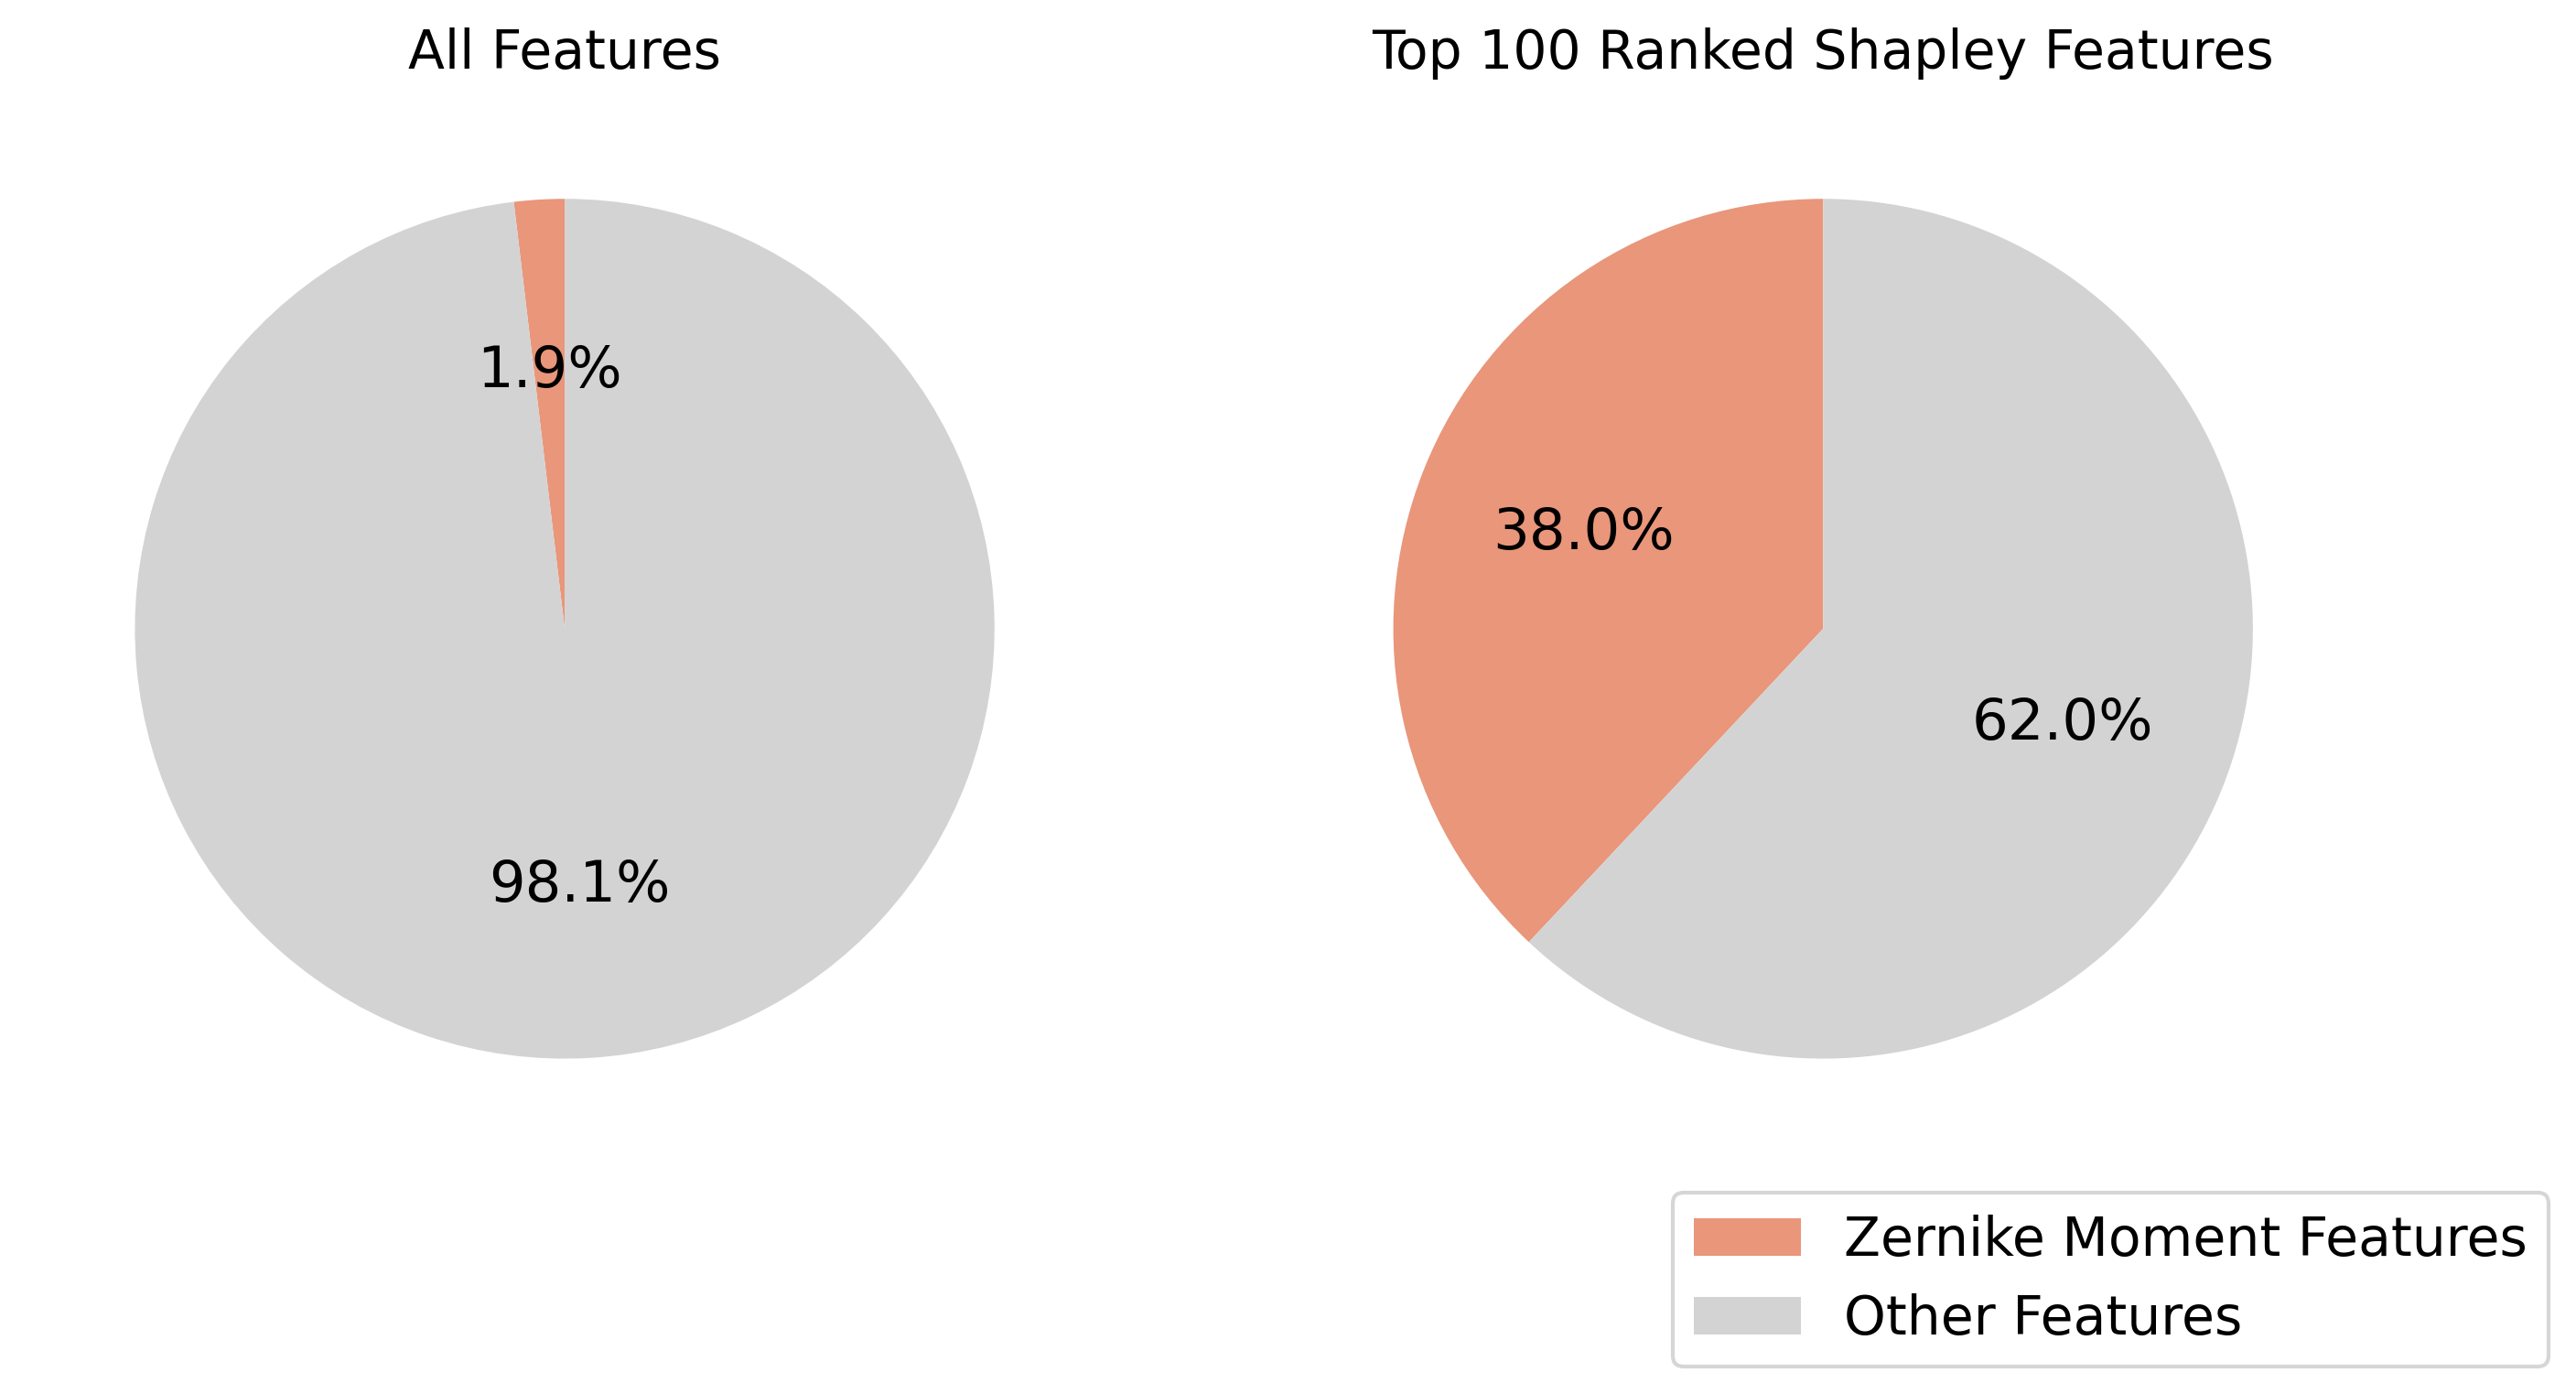

In [75]:
# Data for the first pie chart
sizes1 = [90, 4762 - 90]  
header1 = 'All Features'

# Data for the second pie chart
sizes2 = [38, 100 - 38]  
header2 = 'Top 100 Ranked Shapley Features'

# Create a figure with two subplots for the pie charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=300)

# Create the first pie chart
ax1.pie(sizes1, autopct='%1.1f%%', startangle=90, colors=['darksalmon', 'lightgrey'])
ax1.set_title(header1, fontsize=14)

# Create the second pie chart
ax2.pie(sizes2, autopct='%1.1f%%', startangle=90, colors=['darksalmon', 'lightgrey'])
ax2.set_title(header2, fontsize=14)

# Add legends
legend_labels = ['Zernike Moment Features', 'Other Features']
ax2.legend(legend_labels, loc='upper right', bbox_to_anchor=(1.2,0), fontsize=14)

# Adjust layout and display the charts
plt.tight_layout()
plt.savefig('output/Shapley/zernike_pie.png', bbox_inches='tight')
plt.show()

## CV Results Plots:

### Feature Importance Line Chart:

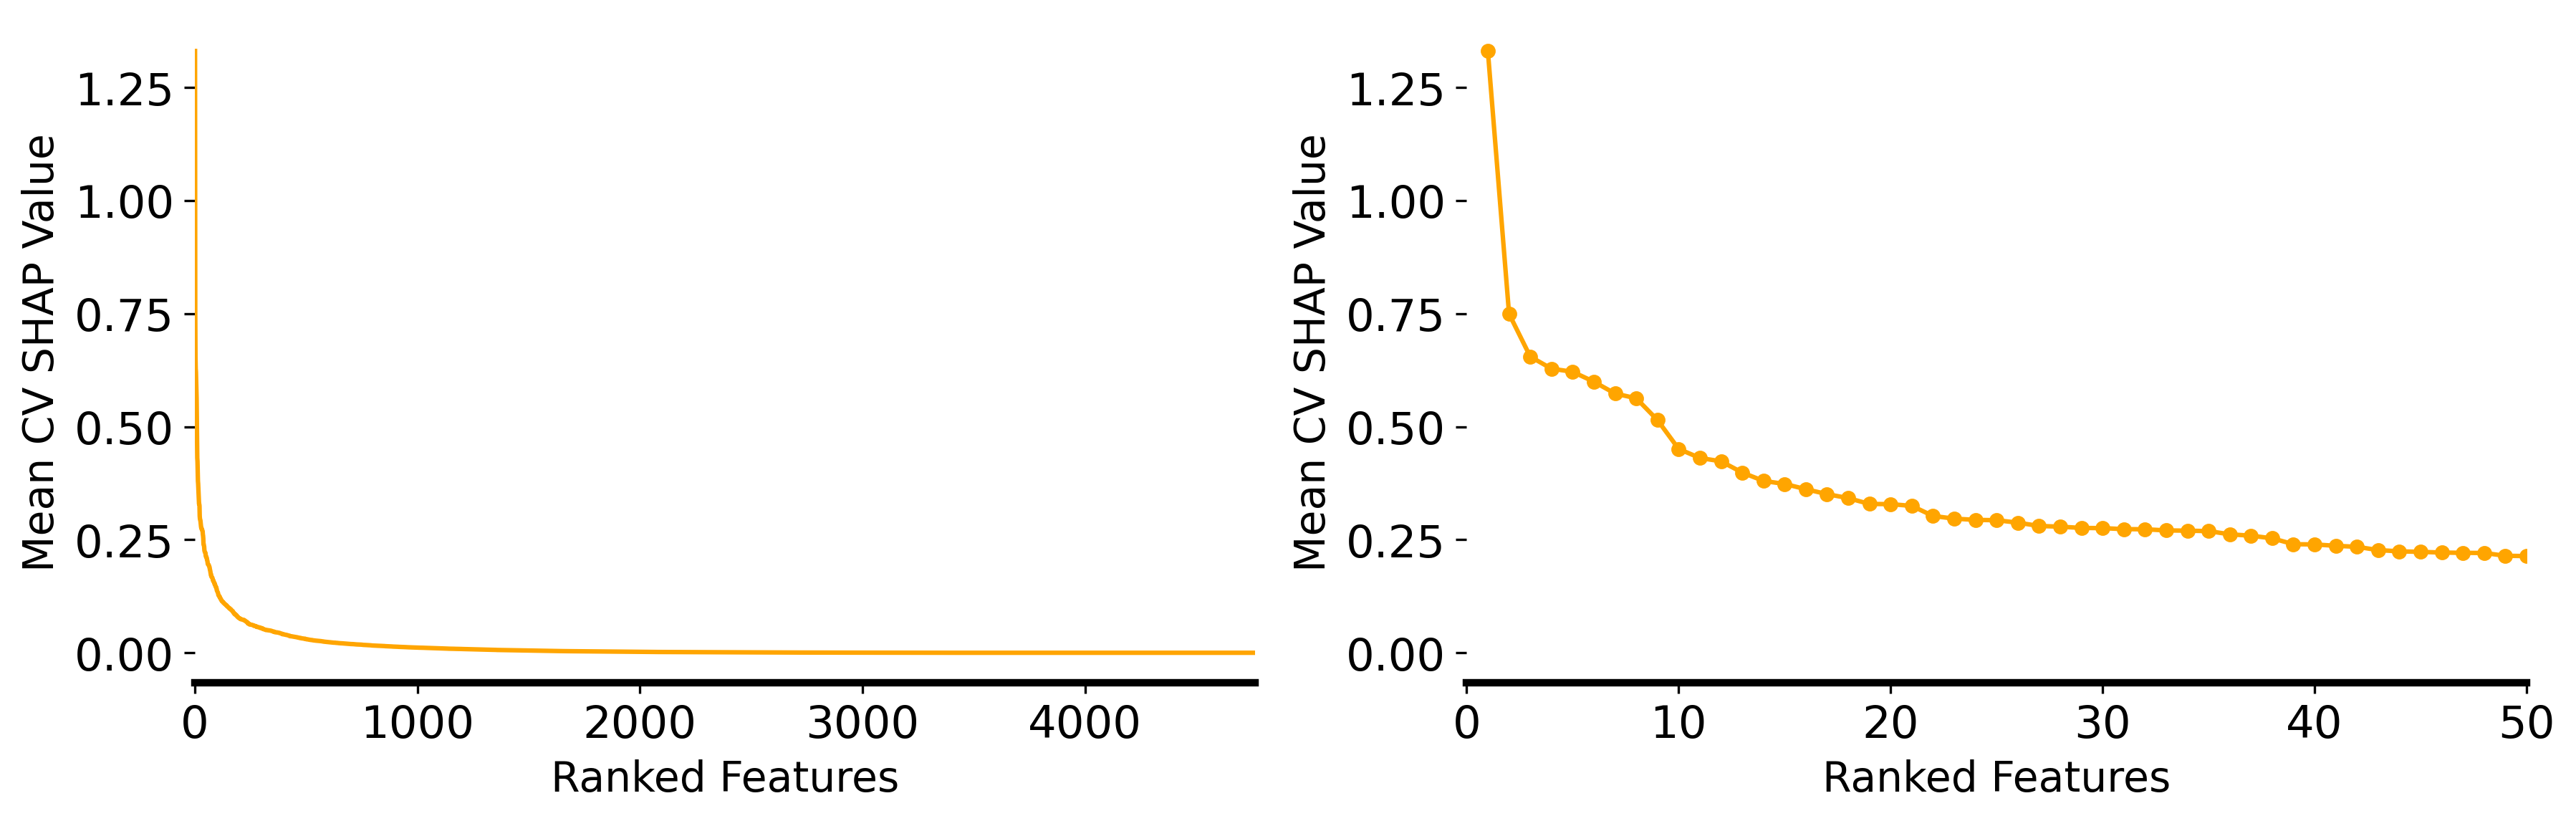

In [14]:
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

fig, ax = plt.subplots(1, 2, figsize = (14, 4), dpi=300)
ax = ax.flatten()

ax[0].plot(cv_results['feature_n'], cv_results['cv_mean'], **{'color': 'orange'})
ax[1].plot(cv_results['feature_n'], cv_results['cv_mean'], **{'color': 'orange'}, marker='o', markersize =4)

for a in range(2):
    ax[a].set_xlabel("Ranked Features", fontsize=14)
    ax[a].set_ylabel("Mean CV SHAP Value", fontsize=14)

ax[0].set_xlim(0, max(cv_results['feature_n']))
ax[1].set_xlim(0, 50)

plt.savefig('output/Shapley/feat_imp.png', bbox_inches='tight')
plt.show()

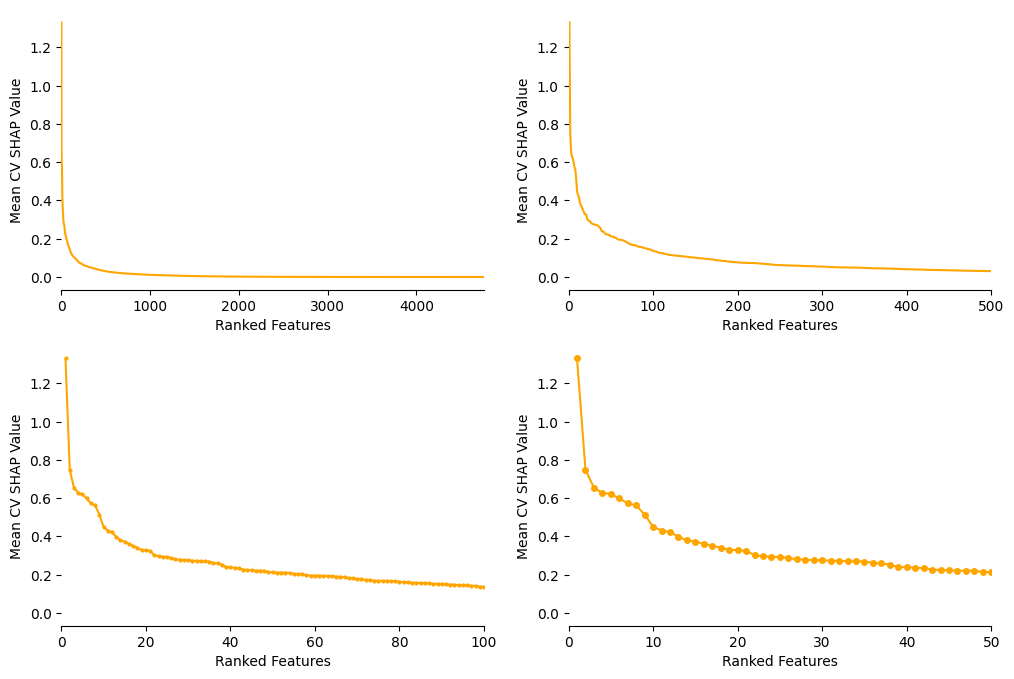

In [31]:
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

fig, ax = plt.subplots(2, 2, figsize = (12, 8))
ax = ax.flatten()

ax[0].plot(cv_results['feature_n'], cv_results['cv_mean'], **{'color': 'orange'})
# ax[1].plot(cv_results['feature_n'], cv_results['cv_mean'], **{'color': 'orange'})
# ax[2].plot(cv_results['feature_n'], cv_results['cv_mean'], **{'color': 'orange'}, marker='o', markersize =2)
ax[3].plot(cv_results['feature_n'], cv_results['cv_mean'], **{'color': 'orange'}, marker='o', markersize =4)

for a in range(4):
    ax[a].set_xlabel("Ranked Features", fontsize=10)
    ax[a].set_ylabel("Mean CV SHAP Value", fontsize=10)

ax[0].set_xlim(0, max(cv_results['feature_n']))
ax[1].set_xlim(0, 500)
ax[2].set_xlim(0, 100)
ax[3].set_xlim(0, 50)

# plt.savefig('output/Shapley/feat_imp.png', bbox_inches='tight')
plt.show()

## Shapely Plots:

In [19]:
def shap_summary_plot(shap_vals, feat_cols, class_dict, title, rgb_cm, save_loc=None):
    # Initialize Shapely plot:
    plt.figure(dpi=300)
    # Custom colormap based on class indices in shap values:
    class_inds = np.argsort([-np.abs(shap_vals[i]).mean() for i in range(len(shap_vals))])
    cmap = plt_colors.ListedColormap(np.array(rgb_cm)[class_inds])

    shap.summary_plot(shap_vals, feat_cols, show = False, color=cmap)

    # Get the Shapely figure and axes objects.
    fig, ax = plt.gcf().set_size_inches(16,6), plt.gca()

    # Adjust legened:
    handles, labels = plt.gca().get_legend_handles_labels()
    # Get class indices in order from summary_plot:
    class_idx = [val for sublist in [[int(s) for s in x.split() if s.isdigit()] for x in labels] for val in sublist]
    # Zip together handles and class indices and sort by index:
    zip_hl = sorted(zip(handles, class_idx), key=lambda x: x[1])
    sorted_hdls = [h[0] for h in zip_hl]
    # Return class names as labels according to index:
    sorted_lbls = [class_dict[x] for x in [l[1] for l in zip_hl]]

    # Modifying main plot parameters
    ax.tick_params(labelsize=6)
    ax.set_xlabel("Mean SHAP value (Impact on model output)", fontsize=10)
    ax.set_title(title, fontsize=12, fontweight='bold')
    plt.legend(fontsize=7, handles= sorted_hdls, labels = sorted_lbls)
    
    if save_loc is not None:
        plt.savefig(save_loc, bbox_inches='tight')
    
    plt.show()

In [21]:
rgb_cm = discrete_colors(len(moa_dict), 'rgb')

### Plots:

In [22]:
# Invert original MOA Label Dictionary:
inv_moa_dict = {value: key for key, value in moa_dict.items()}
inv_moa_dict

{0: 'PI3K',
 1: 'p38 MAPK',
 2: 'RAF',
 3: 'AURK',
 4: 'CDK',
 5: 'EGFR',
 6: 'ROCK',
 7: 'MEK',
 8: 'GSK',
 9: 'mTOR'}

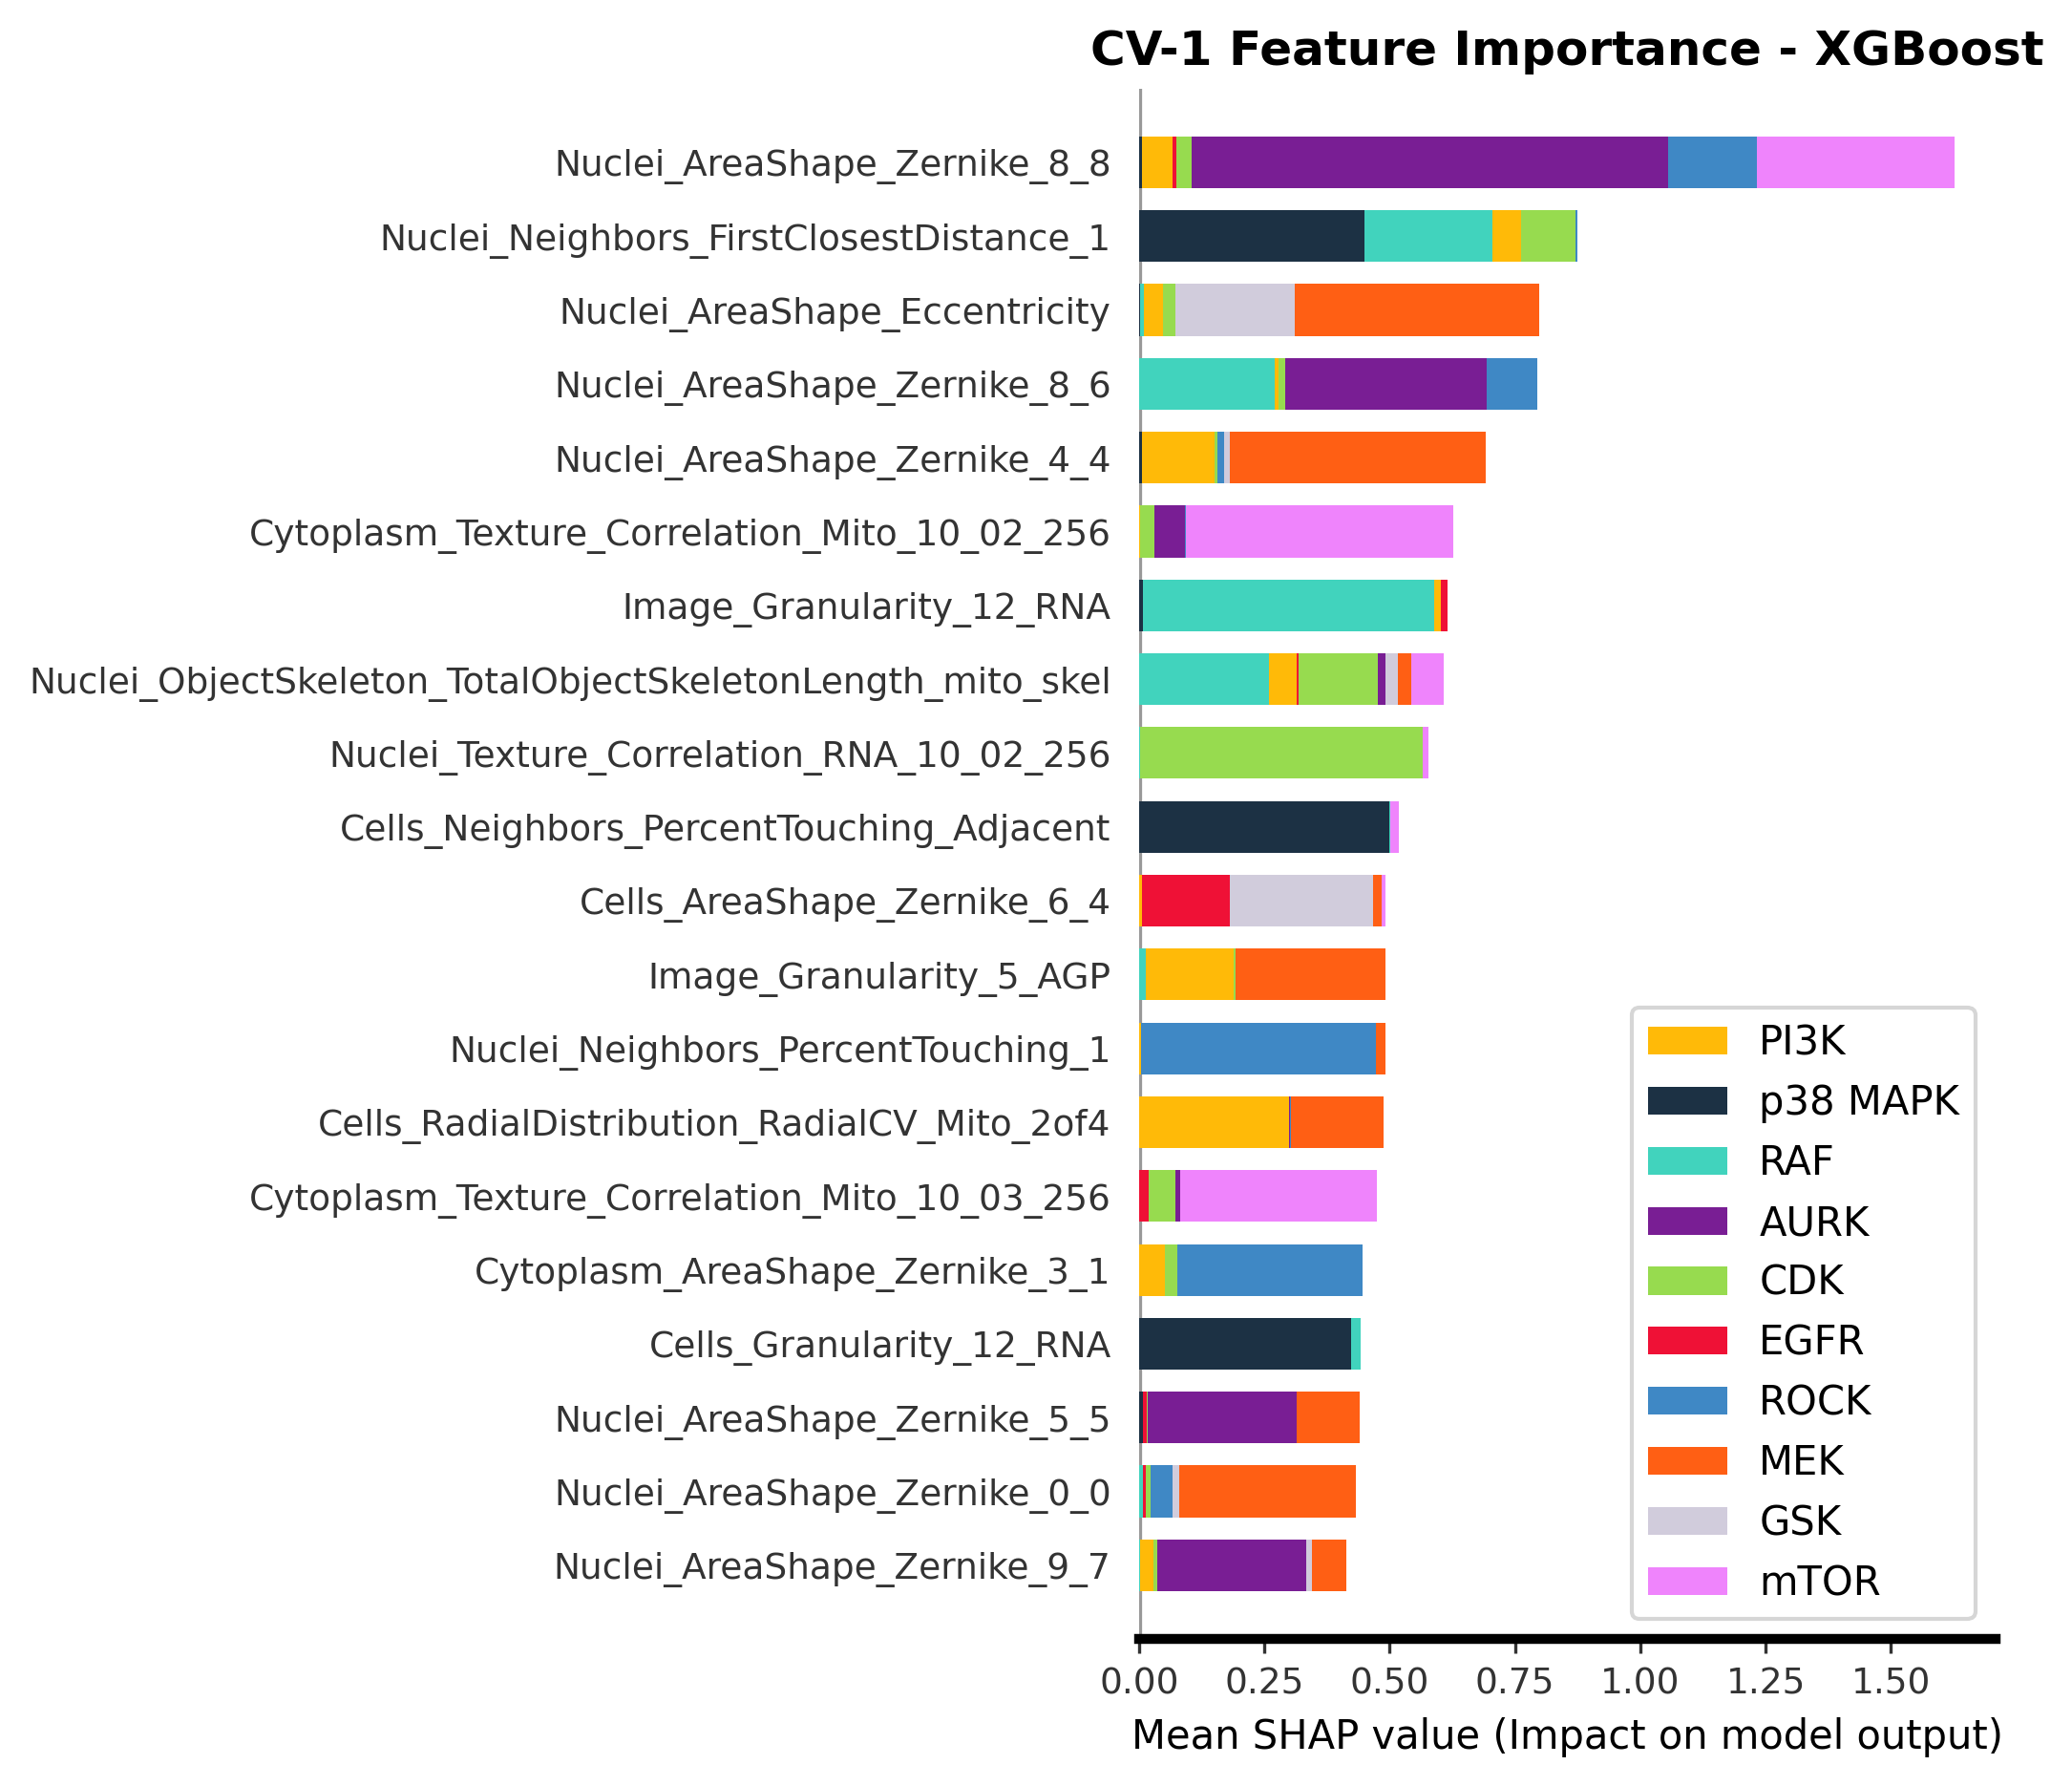

In [25]:
shap_summary_plot(cv_sv[0], feat_cols, inv_moa_dict, 'CV-1 Feature Importance - XGBoost', rgb_cm)

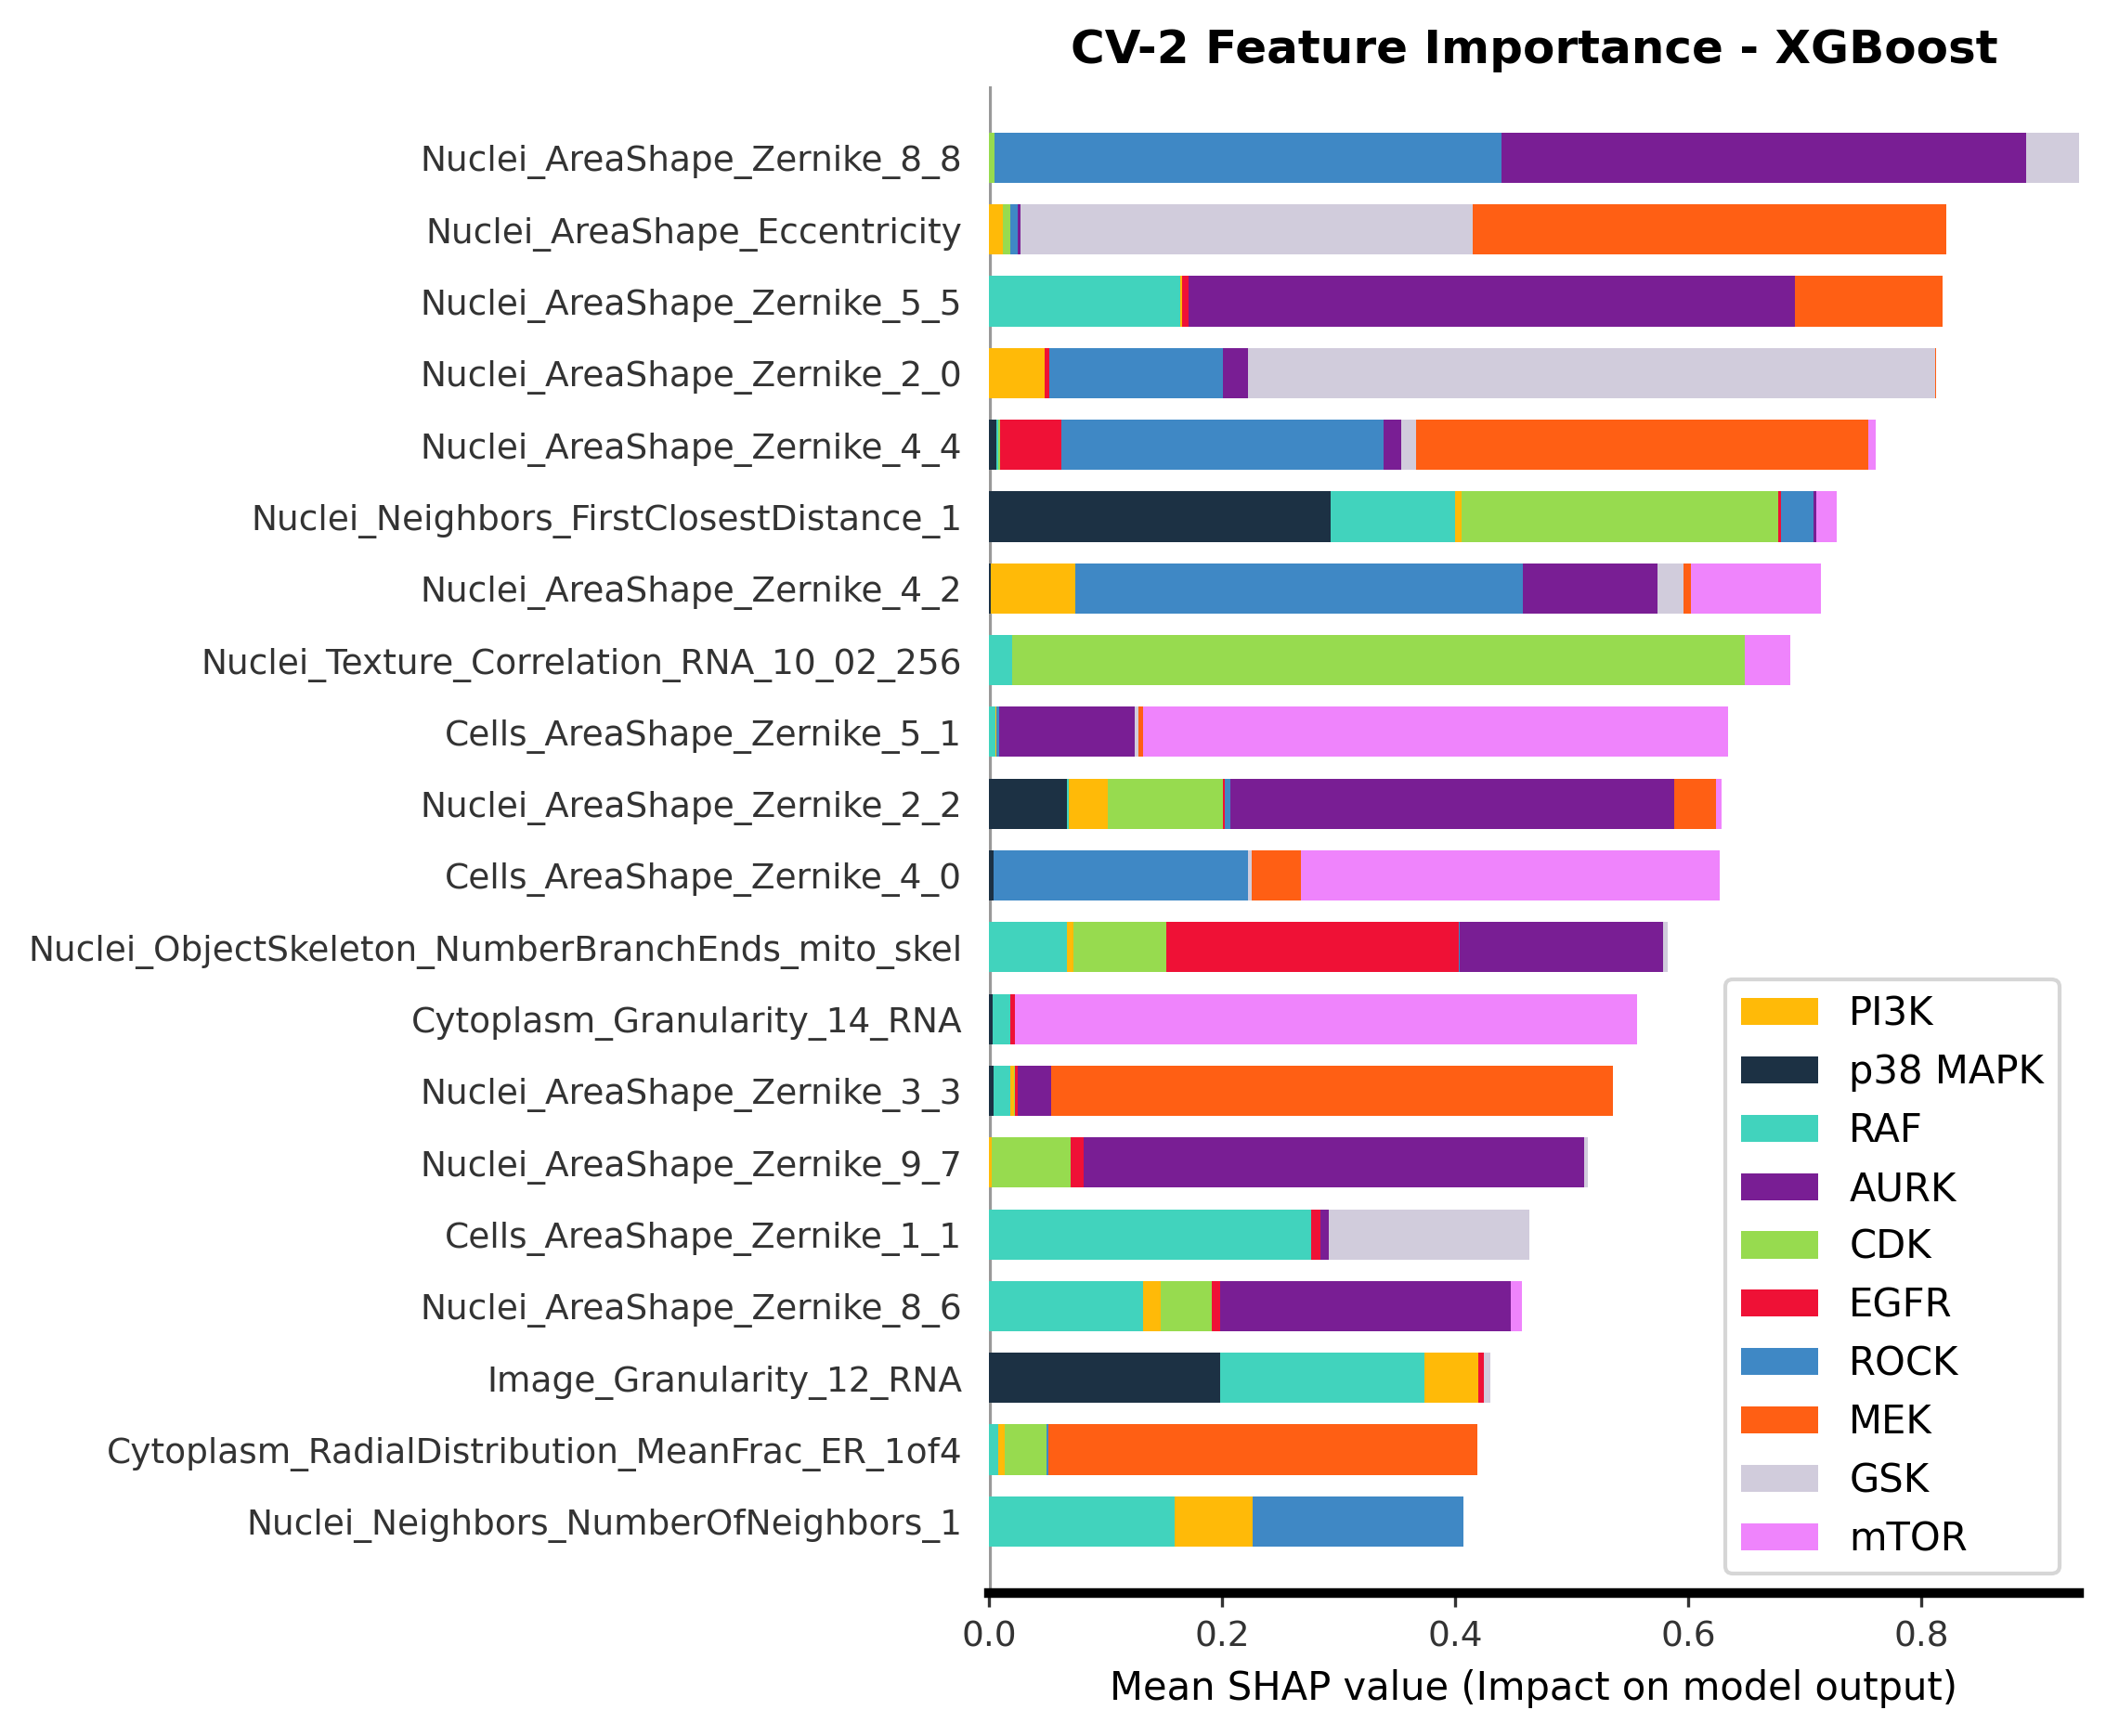

In [48]:
shap_summary_plot(cv_sv[1], feat_cols, inv_moa_dict, 'CV-2 Feature Importance - XGBoost', rgb_cm)

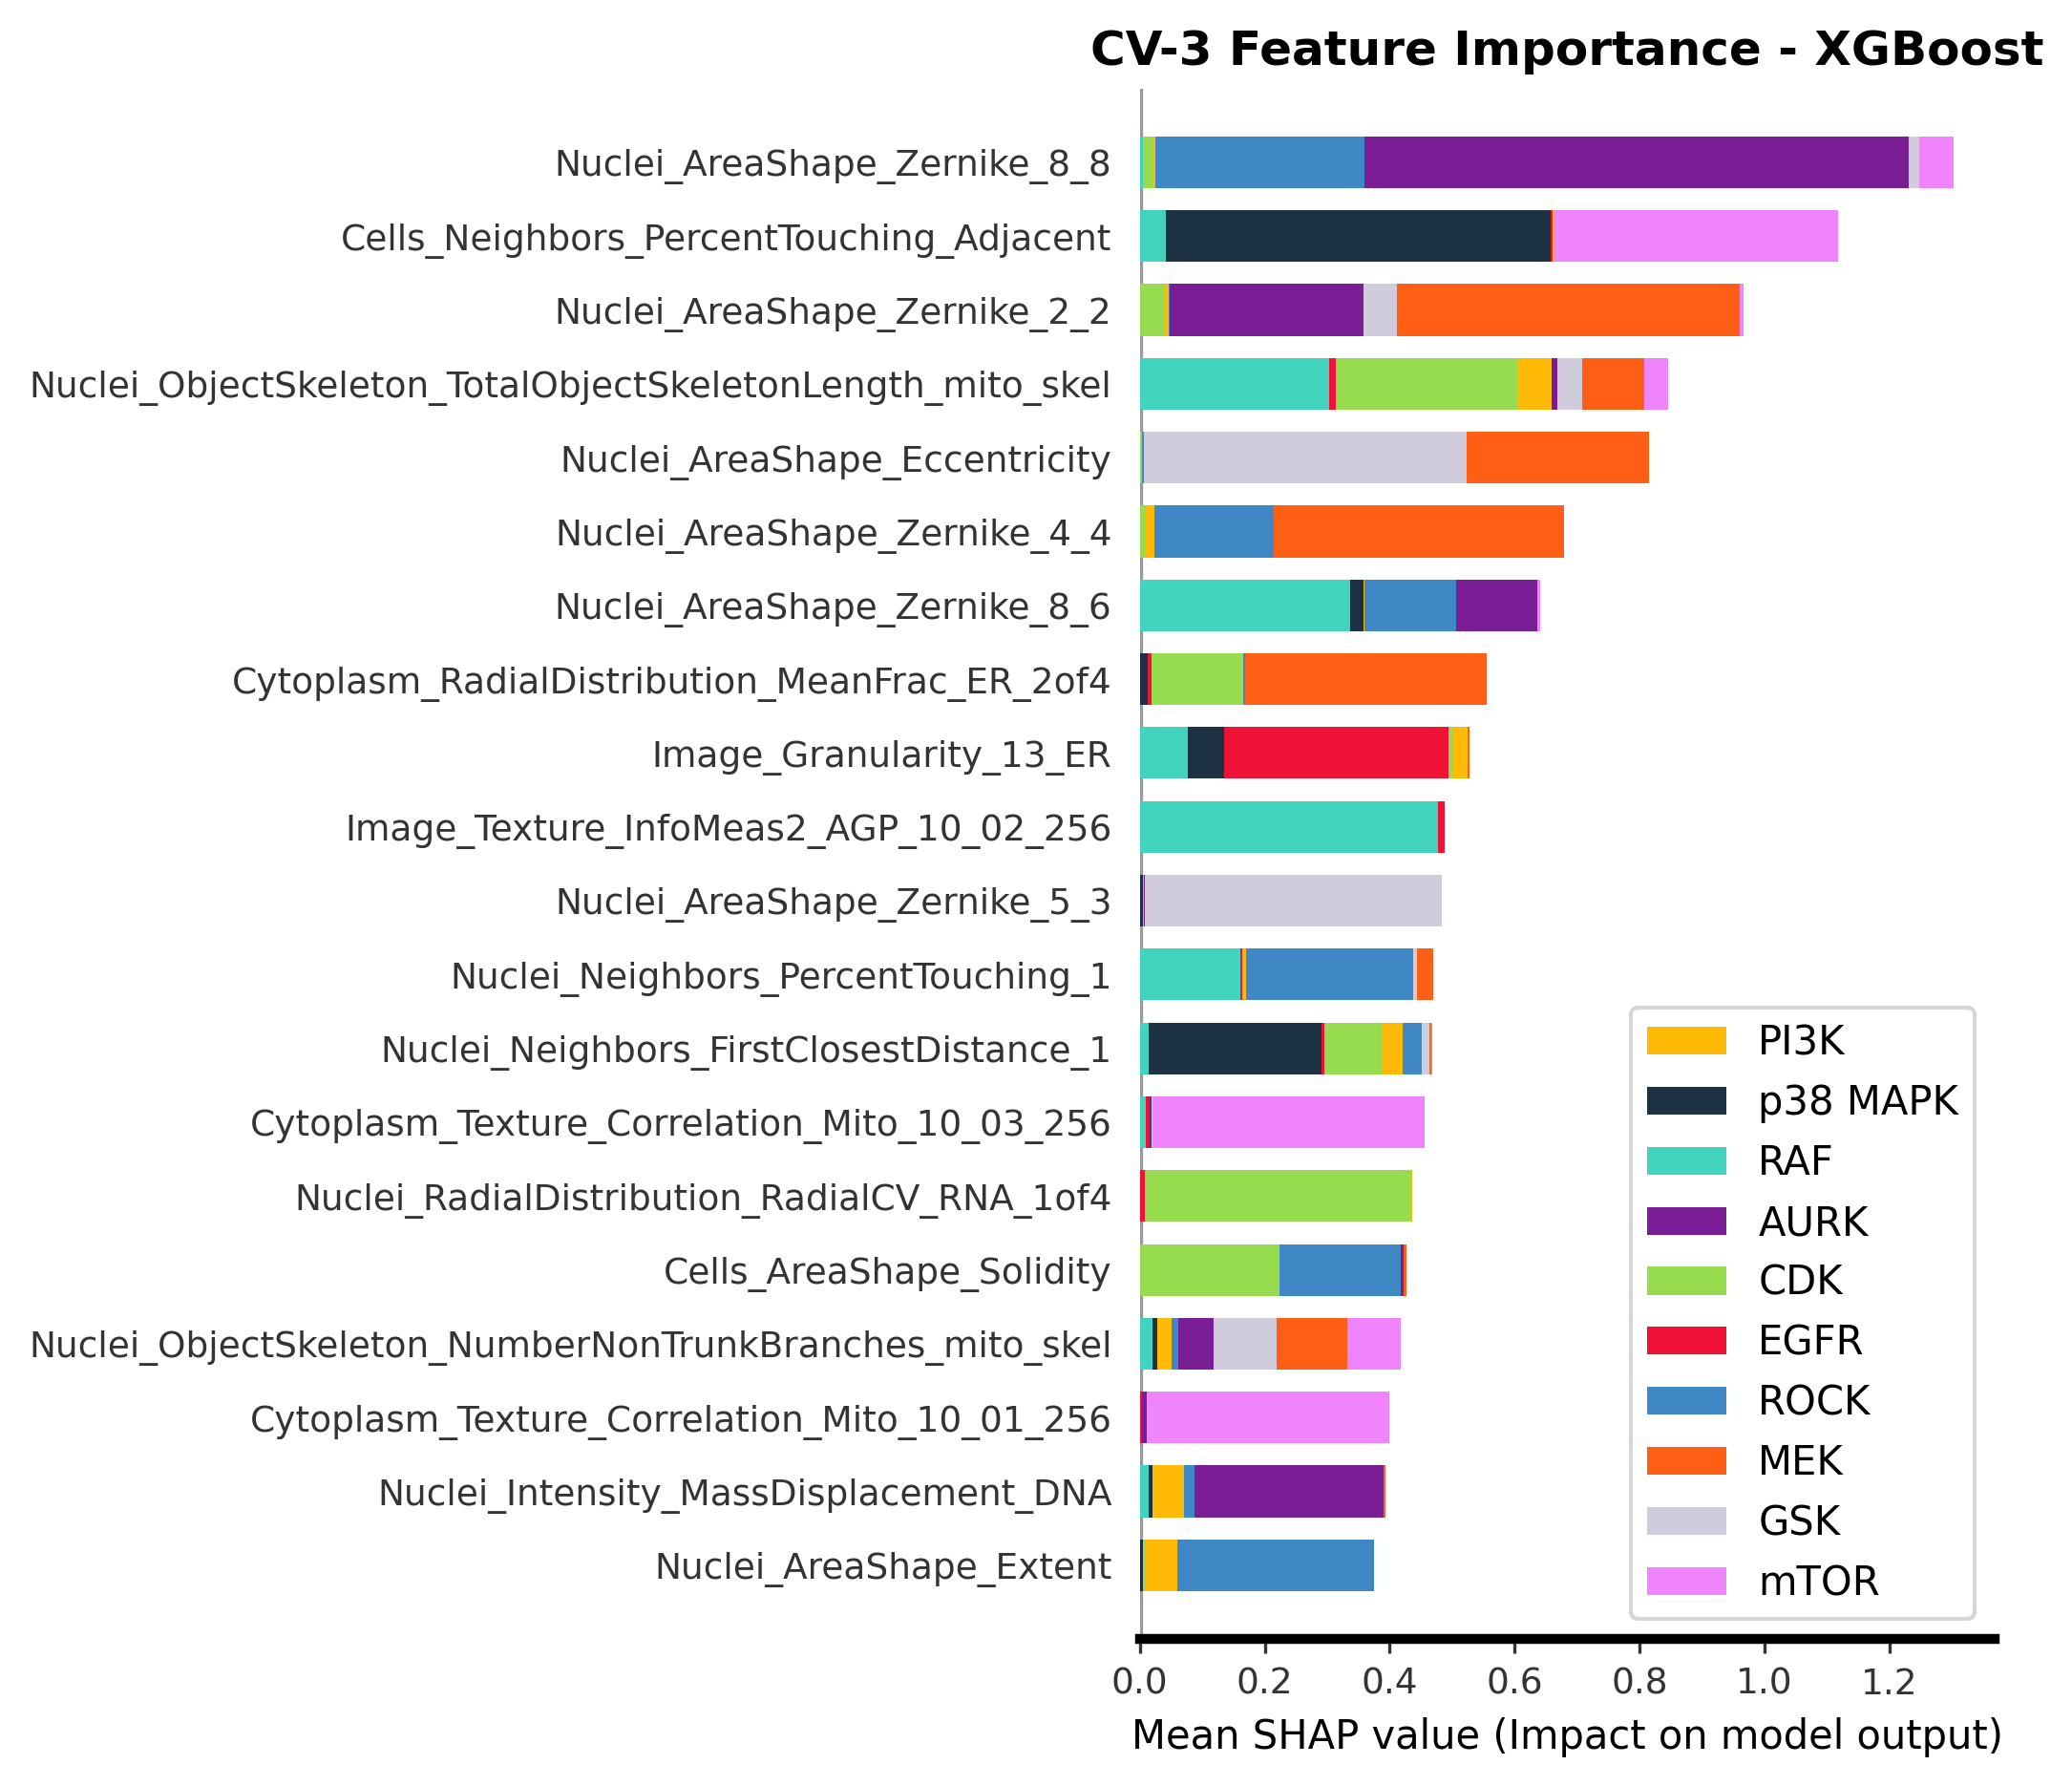

In [49]:
shap_summary_plot(cv_sv[2], feat_cols, inv_moa_dict, 'CV-3 Feature Importance - XGBoost', rgb_cm)

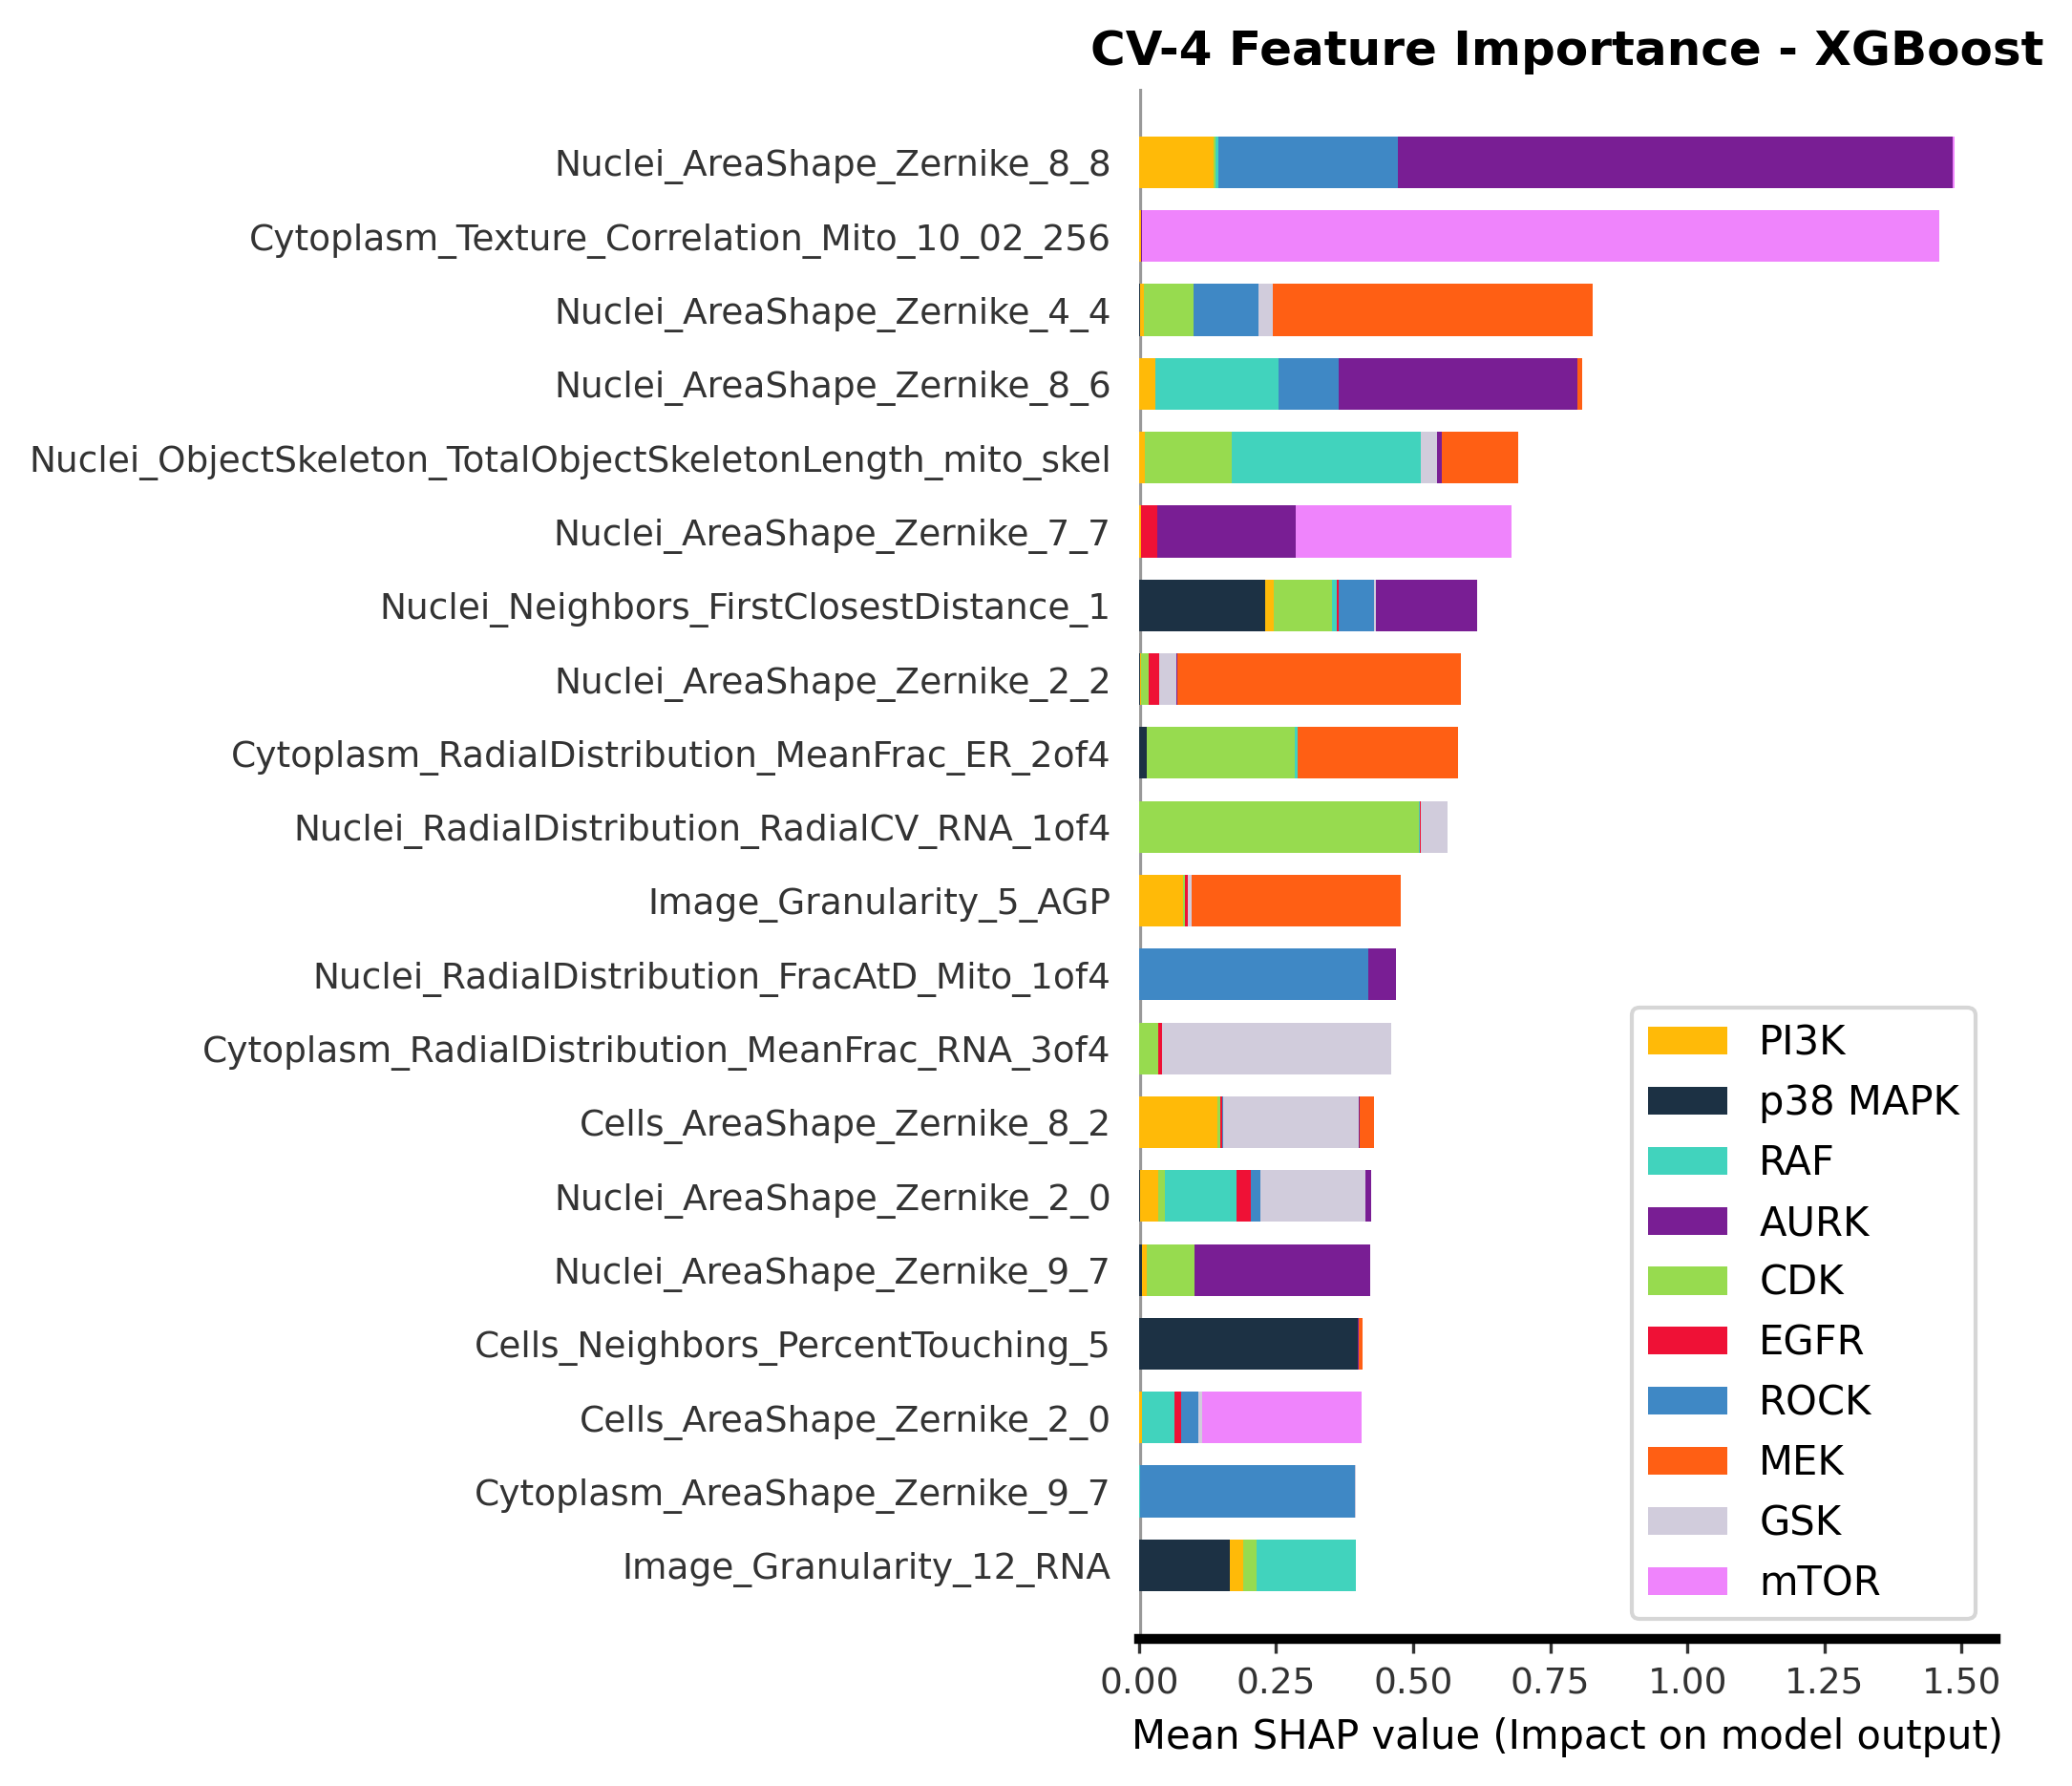

In [50]:
shap_summary_plot(cv_sv[3], feat_cols, inv_moa_dict, 'CV-4 Feature Importance - XGBoost', rgb_cm)

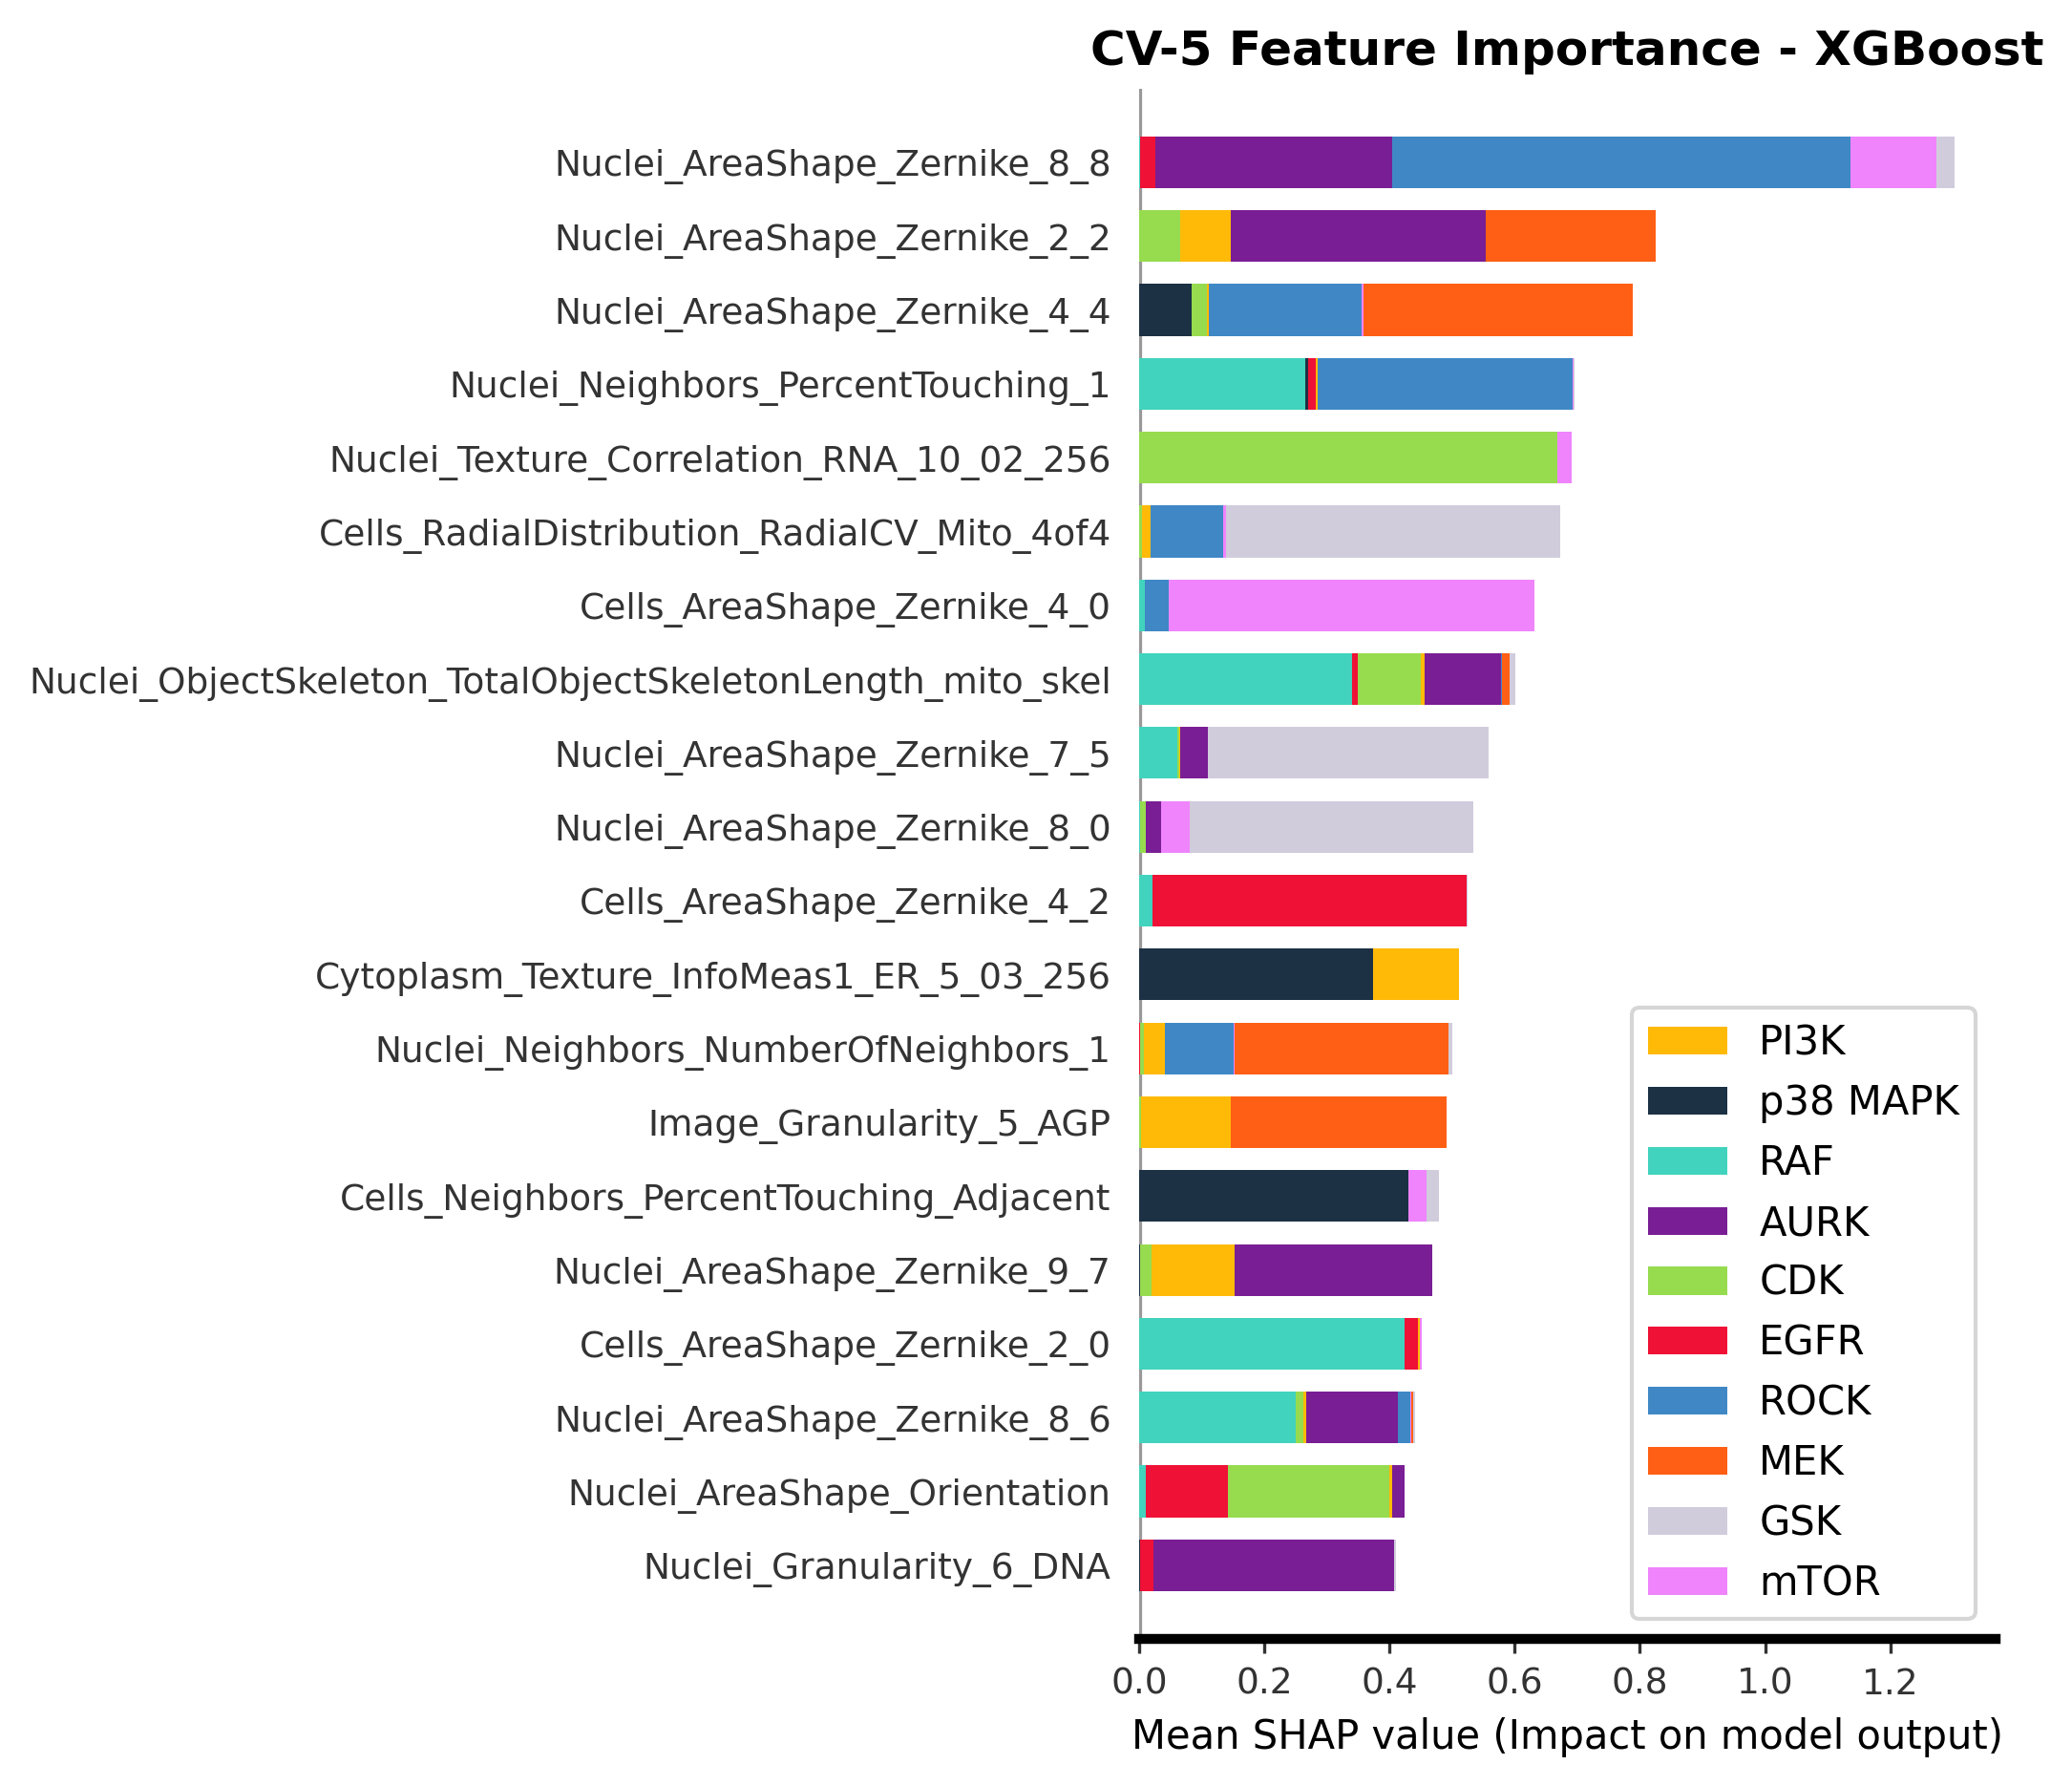

In [26]:
shap_summary_plot(cv_sv[4], feat_cols, inv_moa_dict, 'CV-5 Feature Importance - XGBoost', rgb_cm)

# Inspecting Important Quality Features:
Before quality control the most important feature was "Image_ImageQuality_Correlation_OrigDNA_50", demonstrating the need for QC to be performed. After QC you can see below the importance of image quality for class prediction has dropped dramatically.

In [27]:
image_quality = cv_results[cv_results['features'].str.contains('ImageQuality')]
image_quality[0:10]

features      sv_0      sv_1  \
71      Image_ImageQuality_Correlation_OrigRNA_20  0.087234  0.076743   
110     Image_ImageQuality_Correlation_OrigDNA_50  0.173430  0.043615   
198    Image_ImageQuality_Correlation_OrigMito_50  0.030890  0.101022   
199  Image_ImageQuality_LocalFocusScore_OrigER_50  0.035822  0.074876   
228        Image_ImageQuality_StdIntensity_OrigER  0.141119  0.054284   
246     Image_ImageQuality_Correlation_OrigDNA_20  0.033996  0.132036   
277     Image_ImageQuality_Correlation_OrigDNA_10  0.037728  0.016421   
282       Image_ImageQuality_MaxIntensity_OrigAGP  0.037539  0.126735   
298      Image_ImageQuality_Correlation_OrigDNA_5  0.003415  0.089976   
310     Image_ImageQuality_Correlation_OrigAGP_50  0.049593  0.028437   

         sv_2      sv_3      sv_4    cv_std   cv_mean  feature_n  
71   0.140485  0.196832  0.364755  0.117278  0.173210         72  
110  0.121913  0.088075  0.193374  0.061263  0.124081        111  
198  0.019597  0.222005  0.009763  0.088804  0.076655        199  
199  0.046022  0.205728  0.019611  0.075037  0.076412        200  
228  0.099268  0.018512  0.035466  0.050012  0.069730        229  
246  0.053436  0.068877  0.024546  0.042459  0.062578        247  
277  0.105154  0.053287  0.074291  0.034092  0.057376        278  
282  0.051470  0.067909  0.000000  0.046476  0.056731        283  
298  0.099543  0.076189  0.003380  0.047383  0.054501        299  
310  0.084720  0.066567  0.029871  0.024152  0.051838        311

# FS Impact on Model Performance:
Evaluating the impact of using the Shapley ranked feature selection on a static XGBoost model for various numbers of features.

In [11]:
# Define model:
xgb_model = XGBClassifier(colsample_bytree = 0.7, learning_rate = 0.05, 
                          max_depth = 3, n_estimators = 500)

## 20 Features:

In [10]:
# Selecting Top n Shapley Features:
n_feats = 20
top_feats = cv_results['features'][0:n_feats].tolist()

cv_fold_eval(xgb_model, cv_data, top_feats)

Well-level Results: 55.73% Accuracy | 52.29% F1 Score
Compound-level Results: 60.00% Accuracy | 50.67% F1 Score
Well-level Results: 35.77% Accuracy | 31.49% F1 Score
Compound-level Results: 36.84% Accuracy | 30.52% F1 Score
Well-level Results: 40.71% Accuracy | 43.26% F1 Score
Compound-level Results: 42.11% Accuracy | 44.17% F1 Score
Well-level Results: 41.27% Accuracy | 40.72% F1 Score
Compound-level Results: 63.16% Accuracy | 60.38% F1 Score
Well-level Results: 32.81% Accuracy | 29.01% F1 Score
Compound-level Results: 52.63% Accuracy | 43.78% F1 Score
---------- Cross-validated Mean Metrics ----------
Well-Level: 41.26% Accuracy (+/- 7.89%) | 39.36% F1 Score (+/- 8.40%) 
Compound-Level: 50.95% Accuracy (+/- 10.11%) | 45.90% F1 Score (+/- 9.76%) 


## 50 Features:

In [12]:
# Selecting Top n Shapley Features:
n_feats = 50
top_feats = cv_results['features'][0:n_feats].tolist()
cv_fold_eval(xgb_model, cv_data, top_feats)

Well-level Results: 58.02% Accuracy | 53.82% F1 Score
Compound-level Results: 75.00% Accuracy | 64.90% F1 Score
Well-level Results: 43.07% Accuracy | 40.21% F1 Score
Compound-level Results: 52.63% Accuracy | 46.71% F1 Score
Well-level Results: 42.48% Accuracy | 45.32% F1 Score
Compound-level Results: 68.42% Accuracy | 73.57% F1 Score
Well-level Results: 46.83% Accuracy | 45.40% F1 Score
Compound-level Results: 73.68% Accuracy | 67.33% F1 Score
Well-level Results: 35.16% Accuracy | 35.49% F1 Score
Compound-level Results: 36.84% Accuracy | 34.56% F1 Score
---------- Cross-validated Mean Metrics ----------
Well-Level: 45.11% Accuracy (+/- 7.48%) | 44.05% F1 Score (+/- 6.11%) 
Compound-Level: 61.32% Accuracy (+/- 14.60%) | 57.42% F1 Score (+/- 14.51%) 


## 100 Features:

In [14]:
# Selecting Top n Shapley Features:
n_feats = 100
top_feats = cv_results['features'][0:n_feats].tolist()
cv_fold_eval(xgb_model, cv_data, top_feats)

Well-level Results: 61.07% Accuracy | 59.25% F1 Score
Compound-level Results: 75.00% Accuracy | 68.33% F1 Score
Well-level Results: 40.15% Accuracy | 36.79% F1 Score
Compound-level Results: 52.63% Accuracy | 47.38% F1 Score
Well-level Results: 43.36% Accuracy | 44.65% F1 Score
Compound-level Results: 57.89% Accuracy | 67.02% F1 Score
Well-level Results: 47.62% Accuracy | 46.45% F1 Score
Compound-level Results: 73.68% Accuracy | 67.33% F1 Score
Well-level Results: 33.59% Accuracy | 31.01% F1 Score
Compound-level Results: 36.84% Accuracy | 33.05% F1 Score
---------- Cross-validated Mean Metrics ----------
Well-Level: 45.16% Accuracy (+/- 9.18%) | 43.63% F1 Score (+/- 9.58%) 
Compound-Level: 59.21% Accuracy (+/- 14.17%) | 56.62% F1 Score (+/- 14.15%) 


## 150 Features:

In [16]:
# Selecting Top n Shapley Features:
n_feats = 150
top_feats = cv_results['features'][0:n_feats].tolist()
cv_fold_eval(xgb_model, cv_data, top_feats)

Well-level Results: 59.54% Accuracy | 57.15% F1 Score
Compound-level Results: 75.00% Accuracy | 68.33% F1 Score
Well-level Results: 40.88% Accuracy | 37.90% F1 Score
Compound-level Results: 52.63% Accuracy | 48.33% F1 Score
Well-level Results: 46.90% Accuracy | 47.80% F1 Score
Compound-level Results: 57.89% Accuracy | 64.00% F1 Score
Well-level Results: 49.21% Accuracy | 47.74% F1 Score
Compound-level Results: 68.42% Accuracy | 59.33% F1 Score
Well-level Results: 37.50% Accuracy | 38.32% F1 Score
Compound-level Results: 47.37% Accuracy | 47.86% F1 Score
---------- Cross-validated Mean Metrics ----------
Well-Level: 46.81% Accuracy (+/- 7.61%) | 45.78% F1 Score (+/- 7.14%) 
Compound-Level: 60.26% Accuracy (+/- 10.14%) | 57.57% F1 Score (+/- 8.25%) 


## 300 Features:

In [22]:
# Selecting Top n Shapley Features:
n_feats = 300
top_feats = cv_results['features'][0:n_feats].tolist()
cv_fold_eval(xgb_model, cv_data, top_feats)

Well-level Results: 58.02% Accuracy | 55.73% F1 Score
Compound-level Results: 80.00% Accuracy | 76.67% F1 Score
Well-level Results: 40.88% Accuracy | 38.72% F1 Score
Compound-level Results: 47.37% Accuracy | 42.44% F1 Score
Well-level Results: 46.90% Accuracy | 48.91% F1 Score
Compound-level Results: 52.63% Accuracy | 54.00% F1 Score
Well-level Results: 48.41% Accuracy | 46.71% F1 Score
Compound-level Results: 68.42% Accuracy | 60.38% F1 Score
Well-level Results: 39.06% Accuracy | 38.43% F1 Score
Compound-level Results: 47.37% Accuracy | 47.50% F1 Score
---------- Cross-validated Mean Metrics ----------
Well-Level: 46.65% Accuracy (+/- 6.68%) | 45.70% F1 Score (+/- 6.54%) 
Compound-Level: 59.16% Accuracy (+/- 12.97%) | 56.20% F1 Score (+/- 11.88%) 


## 500 Features:

In [18]:
# Selecting Top n Shapley Features:
n_feats = 500
top_feats = cv_results['features'][0:n_feats].tolist()
cv_fold_eval(xgb_model, cv_data, top_feats)

Well-level Results: 61.07% Accuracy | 57.21% F1 Score
Compound-level Results: 85.00% Accuracy | 84.67% F1 Score
Well-level Results: 39.42% Accuracy | 37.11% F1 Score
Compound-level Results: 47.37% Accuracy | 42.44% F1 Score
Well-level Results: 44.25% Accuracy | 46.61% F1 Score
Compound-level Results: 47.37% Accuracy | 44.00% F1 Score
Well-level Results: 47.62% Accuracy | 46.71% F1 Score
Compound-level Results: 68.42% Accuracy | 59.33% F1 Score
Well-level Results: 39.06% Accuracy | 36.88% F1 Score
Compound-level Results: 47.37% Accuracy | 46.86% F1 Score
---------- Cross-validated Mean Metrics ----------
Well-Level: 46.28% Accuracy (+/- 8.05%) | 44.90% F1 Score (+/- 7.52%) 
Compound-Level: 59.11% Accuracy (+/- 15.30%) | 55.46% F1 Score (+/- 15.77%) 


## 1000 Features:

In [23]:
# Selecting Top n Shapley Features:
n_feats = 1000
top_feats = cv_results['features'][0:n_feats].tolist()
cv_fold_eval(xgb_model, cv_data, top_feats)

Well-level Results: 61.07% Accuracy | 59.61% F1 Score
Compound-level Results: 75.00% Accuracy | 68.33% F1 Score
Well-level Results: 40.88% Accuracy | 36.49% F1 Score
Compound-level Results: 47.37% Accuracy | 43.67% F1 Score
Well-level Results: 46.02% Accuracy | 48.39% F1 Score
Compound-level Results: 52.63% Accuracy | 51.67% F1 Score
Well-level Results: 41.27% Accuracy | 40.14% F1 Score
Compound-level Results: 68.42% Accuracy | 60.38% F1 Score
Well-level Results: 35.16% Accuracy | 33.66% F1 Score
Compound-level Results: 42.11% Accuracy | 36.50% F1 Score
---------- Cross-validated Mean Metrics ----------
Well-Level: 44.88% Accuracy (+/- 8.80%) | 43.66% F1 Score (+/- 9.39%) 
Compound-Level: 57.11% Accuracy (+/- 12.55%) | 52.11% F1 Score (+/- 11.37%) 


## All Features:

In [24]:
cv_fold_eval(xgb_model, cv_data)

Well-level Results: 59.54% Accuracy | 58.24% F1 Score
Compound-level Results: 75.00% Accuracy | 68.33% F1 Score
Well-level Results: 40.88% Accuracy | 37.47% F1 Score
Compound-level Results: 42.11% Accuracy | 32.00% F1 Score
Well-level Results: 46.02% Accuracy | 47.52% F1 Score
Compound-level Results: 47.37% Accuracy | 44.00% F1 Score
Well-level Results: 42.86% Accuracy | 41.74% F1 Score
Compound-level Results: 68.42% Accuracy | 59.33% F1 Score
Well-level Results: 34.38% Accuracy | 32.99% F1 Score
Compound-level Results: 42.11% Accuracy | 38.33% F1 Score
---------- Cross-validated Mean Metrics ----------
Well-Level: 44.73% Accuracy (+/- 8.33%) | 43.59% F1 Score (+/- 8.76%) 
Compound-Level: 55.00% Accuracy (+/- 13.93%) | 48.40% F1 Score (+/- 13.47%) 


## PyCy Features:

In [8]:
# Load Spherized and Harmonized Data:
pycy_spher = 'output/MAD_Sphere/MADS_PyCyFS.pkl'

with open(pycy_spher, 'rb') as file:
    loaded_data = pickle.load(file)
    
# Specify the prefix to remove
prefix_to_remove = 'sph_'
loaded_data = rr_prefix(loaded_data, prefix_to_remove)
pycy_feats = loaded_data[0]['X_train'].columns.tolist()

In [16]:
cv_fold_eval(xgb_model, cv_data, pycy_feats)

Well-level Results: 57.25% Accuracy | 55.28% F1 Score
Compound-level Results: 80.00% Accuracy | 80.67% F1 Score
Well-level Results: 38.69% Accuracy | 36.64% F1 Score
Compound-level Results: 47.37% Accuracy | 42.44% F1 Score
Well-level Results: 45.13% Accuracy | 45.05% F1 Score
Compound-level Results: 52.63% Accuracy | 51.67% F1 Score
Well-level Results: 39.68% Accuracy | 39.23% F1 Score
Compound-level Results: 63.16% Accuracy | 54.83% F1 Score
Well-level Results: 31.25% Accuracy | 30.53% F1 Score
Compound-level Results: 42.11% Accuracy | 37.56% F1 Score
---------- Cross-validated Mean Metrics ----------
Well-Level: 42.40% Accuracy (+/- 8.64%) | 41.35% F1 Score (+/- 8.38%) 
Compound-Level: 57.05% Accuracy (+/- 13.42%) | 53.43% F1 Score (+/- 14.96%) 


## Plotting Results:

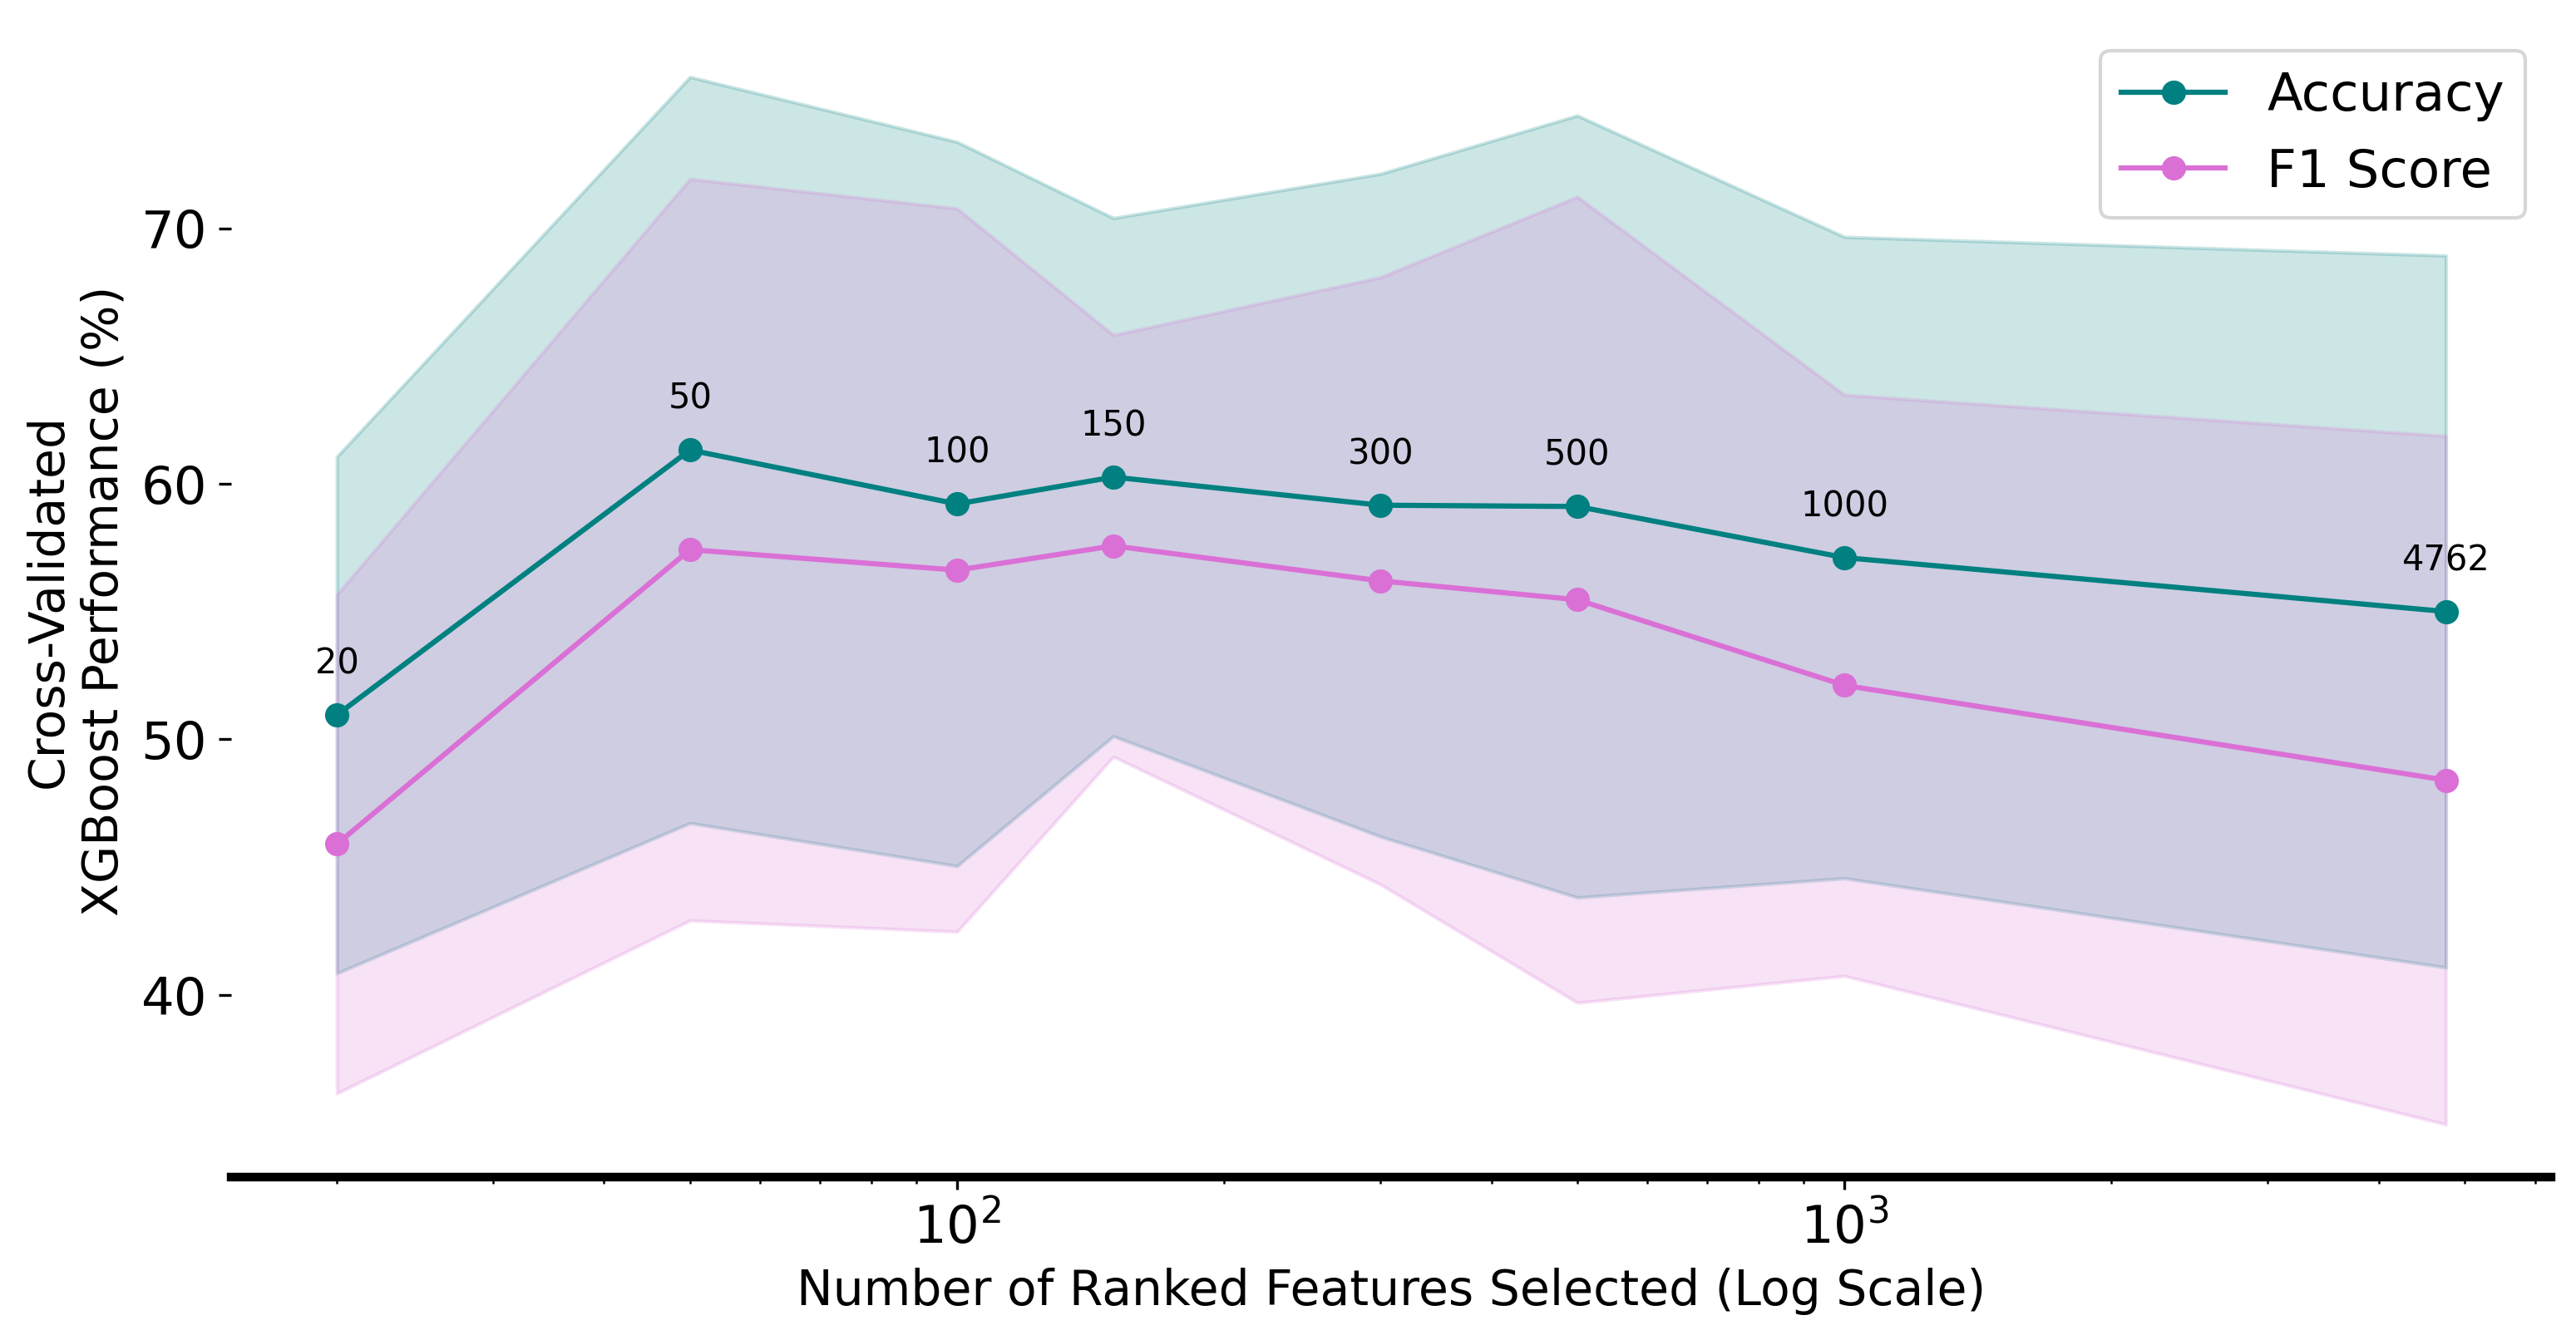

In [41]:
# Data
no_features = [20, 50, 100, 150, 300, 500, 1000, 4762]
model_accuracy = [50.95, 61.32, 59.21, 60.26, 59.16, 59.11, 57.11, 55.00]
accuracy_std = [10.11, 14.60, 14.17, 10.14, 12.97, 15.30, 12.55, 13.93]
model_f1 = [45.90, 57.42, 56.62, 57.57, 56.20, 55.46, 52.11, 48.40]
f1_std = [9.76, 14.51, 14.15, 8.25, 11.88, 15.77, 11.37, 13.47]

# Create the figure and axis
fig, ax = plt.subplots(figsize = (12, 6), dpi=300)

# Plot the accuracy line with shaded area
ax.plot(no_features, model_accuracy, label='Accuracy', marker='o', color='teal')
ax.fill_between(no_features, np.array(model_accuracy) - np.array(accuracy_std), 
                np.array(model_accuracy) + np.array(accuracy_std), alpha=0.2, color='teal')

# Plot the F1 score line with shaded area
ax.plot(no_features, model_f1, label='F1 Score', marker='o', color='orchid')
ax.fill_between(no_features, np.array(model_f1) - np.array(f1_std), 
                np.array(model_f1) + np.array(f1_std), alpha=0.2, color='orchid')

# Set x-axis to a logarithmic scale
ax.set_xscale('log')

# Set labels and title
ax.set_xlabel('Number of Ranked Features Selected (Log Scale)', fontsize=14)
ax.set_ylabel('Cross-Validated\nXGBoost Performance (%)', fontsize=14)
ax.legend()

# Add labels for each data point
for i, features in enumerate(no_features):
    ax.annotate(str(features), (no_features[i], model_accuracy[i]), 
                textcoords="offset points", xytext=(0, 12), ha='center', fontsize=10)

# ax.text(0.1, 0.1, 'Shaded area represents Standard Deviation', transform=ax.transAxes)
plt.savefig('output/Shapley/model_impact.png', bbox_inches='tight')

# Show the plot
plt.show()

# Shapley Importance with MAD Norm/ Spher/ Feature Selection Applied:
Calculating Shapley feature importance per class post normalization, standardization and feature selection techniques that were explored in other notebooks.

## Load Data:

In [61]:
pycy_spher = 'output/MAD_Sphere/MADS_PyCyFS.pkl'
shap_spher = 'output/MAD_Sphere/MADS_ShapFS.pkl'
pycy_harm = 'output/MAD_Harmony/MAD_Harmony_PyCyFS.pkl'
shap_harm = 'output/MAD_Harmony/MAD_Harmony_ShapFS.pkl'

with open(shap_spher, 'rb') as file:
    loaded_data = pickle.load(file)

## Fit Model and Calc. Shapley Values:

In [8]:
def shap_cv(cv_data, model, feat_names):
    
    cv_cols = []
    cv_shap_vals = []
    
    # Return cross-validated data splits:
    for cv in range(len(cv_data)):
        print("Beginning CV %s..." % (cv+1))       
        # Copy model:
        cv_mod = copy.deepcopy(model)
        # Fit the model on the training data:
        cv_mod.fit(cv_data[f'CV{cv}']['sph_X_train'], cv_data[f'CV{cv}']['sph_y_train'])
        
        # Define tree explainer:
        mod_exp = shap.TreeExplainer(cv_mod)
        # Generate Shapely values using test set:
        shap_vals = mod_exp.shap_values(cv_data[f'CV{cv}']['sph_X_test'])
        cv_shap_vals.append(shap_vals)
        # Dataframe of shapley values per feature:
        shap_df, cv_col = global_shap_importance(shap_vals, feat_names, cv)
        cv_cols.append(cv_col)
        
        if cv == 0:
            res_df = shap_df
        else:
            res_df = pd.merge(res_df, shap_df, on='features')
            
    # Calculate mean and std across cv folds:
    res_df['cv_std'] = res_df[cv_cols].std(axis=1)
    res_df['cv_mean'] = res_df[cv_cols].mean(axis=1)
     
    # Sort by mean shapley values:
    res_df.sort_values(by=['cv_mean'], ascending=False, inplace=True)
    res_df = res_df.reset_index(drop=True)
    
    return res_df, cv_shap_vals

In [60]:
xgb_model = XGBClassifier(n_estimators = 400, subsample=0.5, colsample_bytree=0.8, learning_rate = 0.05, 
                          max_depth=15, colsample_bylevel=0.4)

In [10]:
f_cols = find_feat_cols(loaded_data[f'CV1']['sph_X_train'])
f_cols[0:5]

['Nuclei_AreaShape_Zernike_8_8',
 'Nuclei_AreaShape_Zernike_4_4',
 'Nuclei_AreaShape_Zernike_2_2',
 'Nuclei_AreaShape_Zernike_8_6',
 'Nuclei_ObjectSkeleton_TotalObjectSkeletonLength_mito_skel']

In [62]:
# Get CV results using validation sets:
xgb_results, xgb_sv = shap_cv(loaded_data, xgb_model, f_cols)

Beginning CV 1...


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Beginning CV 2...


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Beginning CV 3...


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Beginning CV 4...


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Beginning CV 5...


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [13]:
# Save CV Results:
xgb_results.to_csv('output/feat_sel/shap_fs_finalres.csv', index=False)

In [63]:
xgb_results['feature_n'] = xgb_results.index + 1
xgb_results.head()

features      sv_0      sv_1      sv_2  \
0                Nuclei_AreaShape_Zernike_0_0  1.237759  1.443303  1.297723   
1       Nuclei_Intensity_MassDisplacement_AGP  0.996886  1.033859  1.047898   
2      Nuclei_Correlation_Correlation_ER_Mito  0.897815  0.649823  1.286027   
3  Cells_RadialDistribution_MeanFrac_DNA_2of4  0.922187  0.908913  0.896692   
4                Nuclei_AreaShape_Compactness  0.966483  0.898532  0.708490   

       sv_3      sv_4    cv_std   cv_mean  feature_n  
0  0.980159  1.348312  0.174368  1.261451          1  
1  1.158711  1.579352  0.240254  1.163341          2  
2  0.695091  1.022723  0.258906  0.910296          3  
3  0.949158  0.722722  0.090019  0.879934          4  
4  0.769198  0.999464  0.125617  0.868433          5

## Combined Shapley Importance:
Importance for each class for each fold combined.

In [ ]:
# Stacking results per fold and then displaying combined SV Plot across folds:
num_folds = 5
num_classes = 10

class_fold_result = []

for i in range(num_classes):
    # Shapley values for a specific class
    class_result = []
    
    for j in range(num_folds):
        # Return mean results array for specific class/fold:
        class_result.append(xgb_sv[j][i])
    
    # Average results across class:
    stacked_array = np.vstack(class_result)
#     print(stacked_array.shape)
    class_fold_result.append(stacked_array)

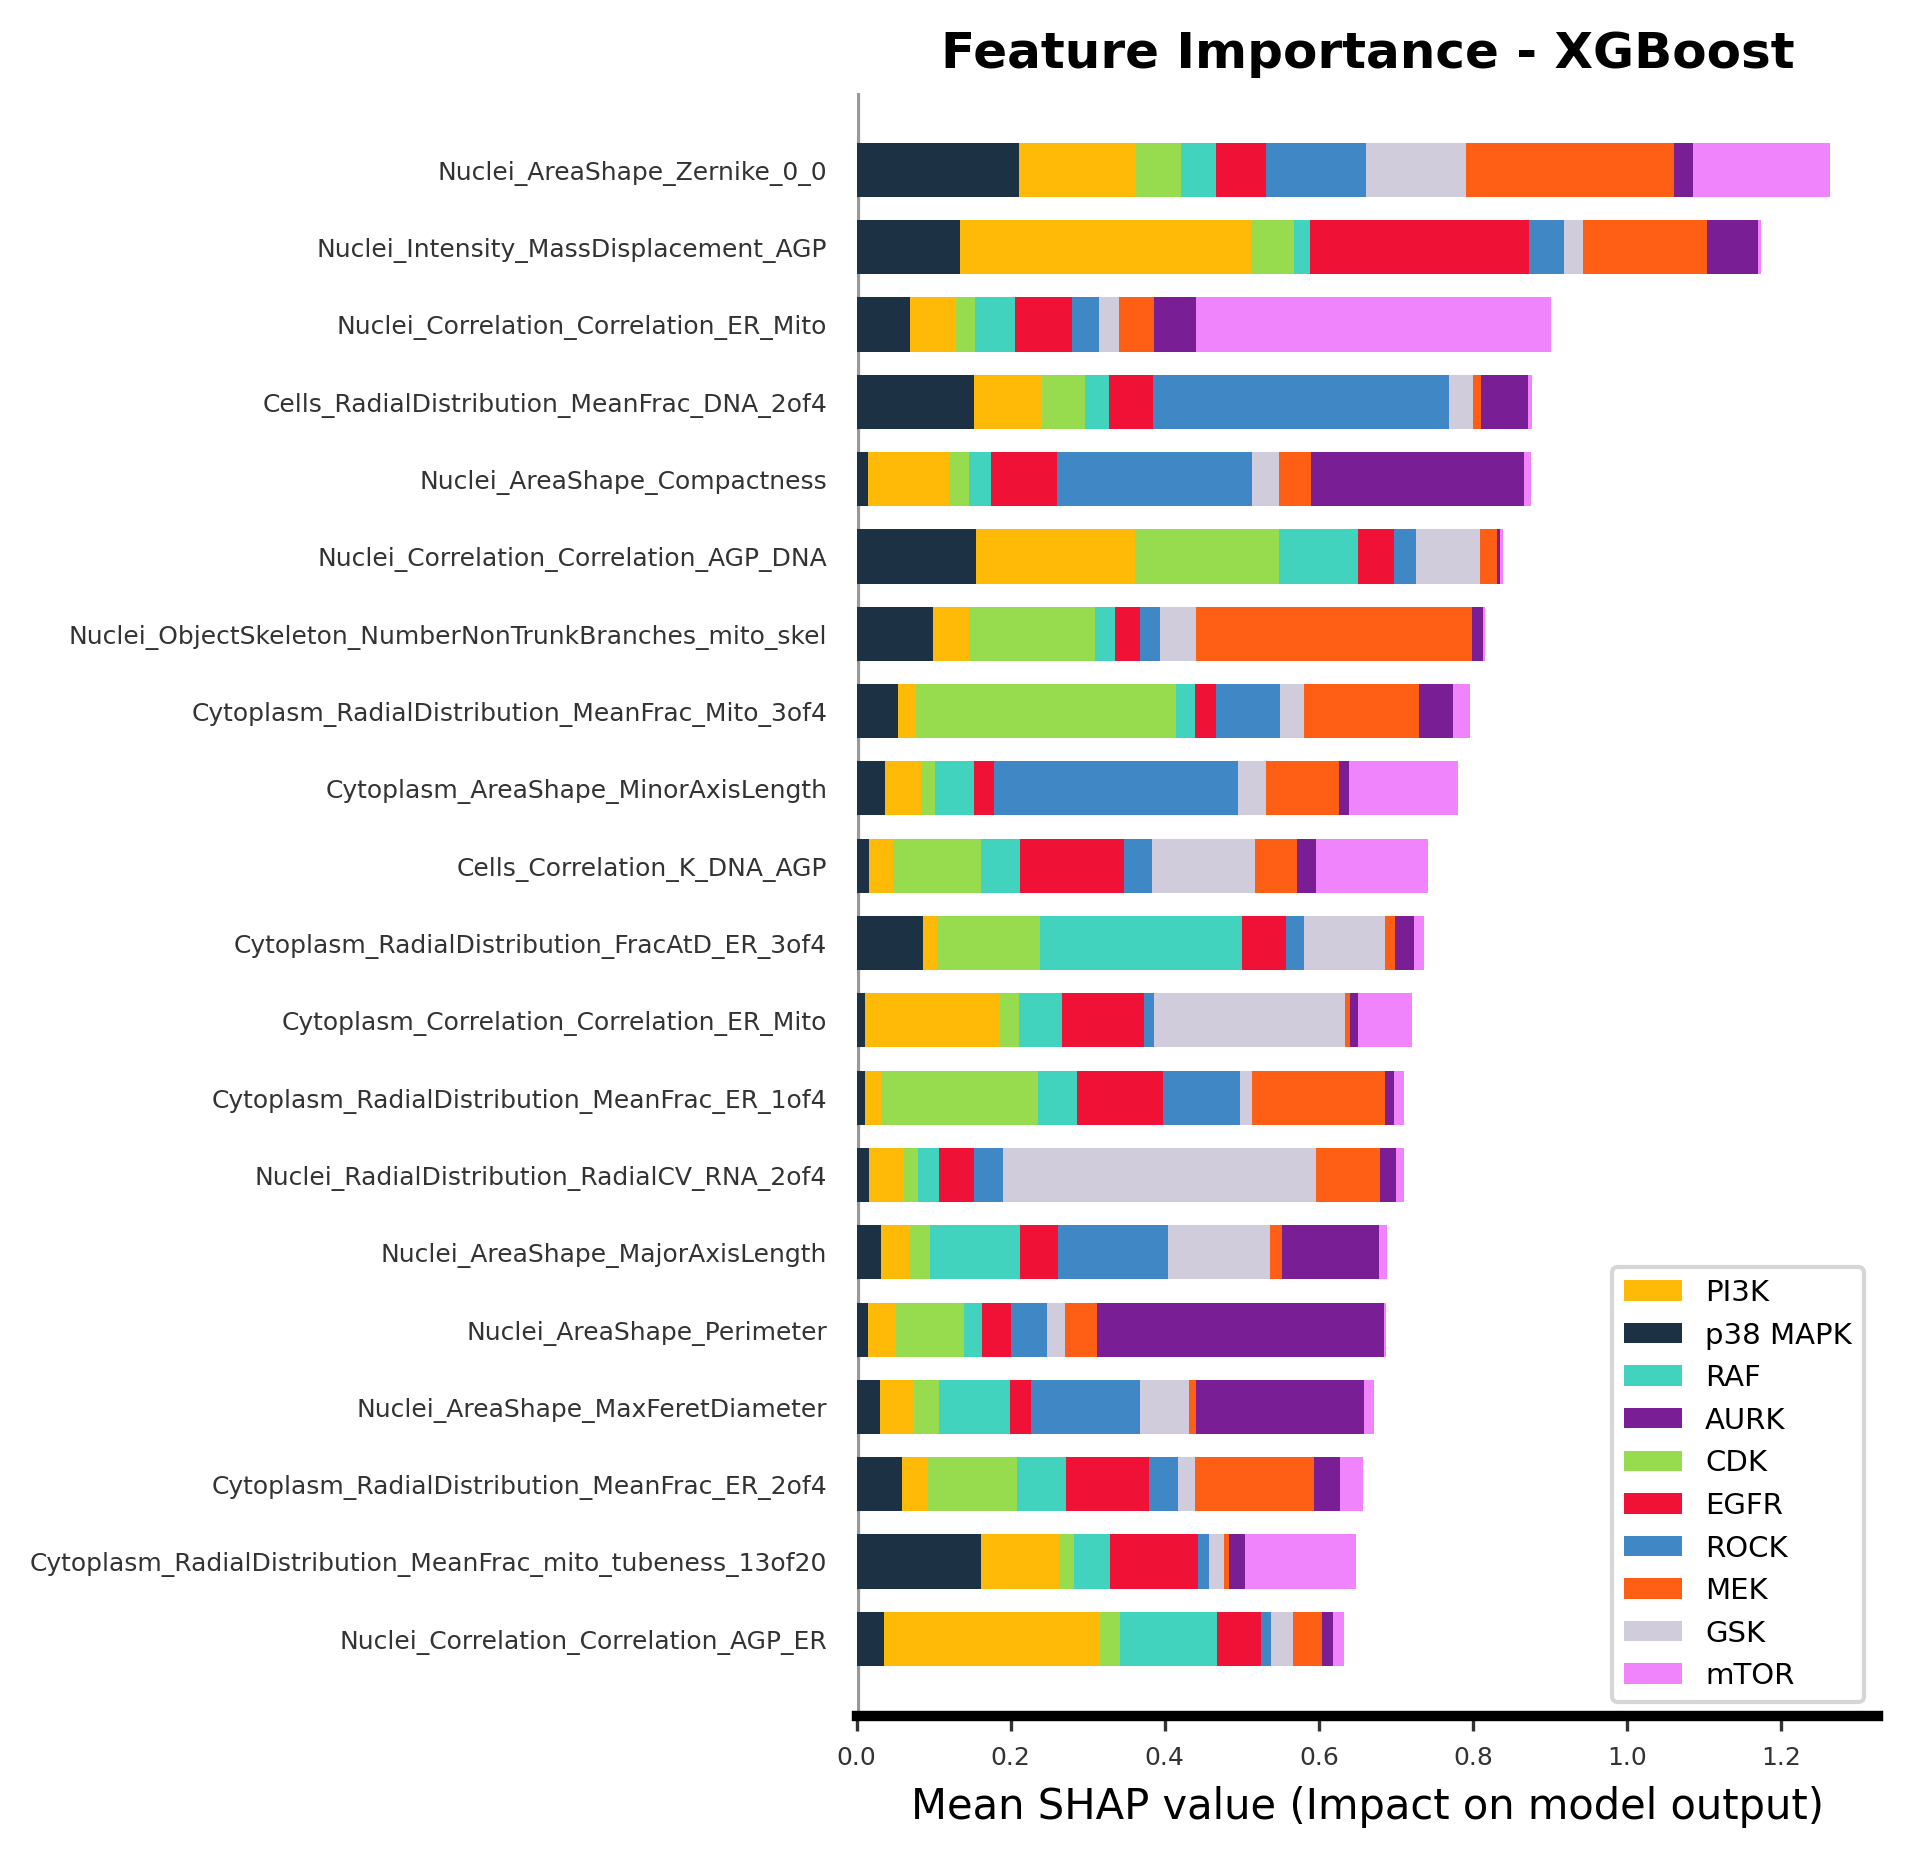

In [70]:
shap_summary_plot(class_fold_result, f_cols, inv_moa_dict, 'Feature Importance - XGBoost', rgb_cm,
                 save_loc='output/Shapley/Combined_SV_Plot.png')

## Shap Importance per MOA Class:
Showing the importance values on a class-specific basis.

In [71]:
def plot_shap_per_moa(shap_vals, moa, feat_cols, n_feats, save_loc=None):
    # Return mean importance per feature:
    abs_shap = np.abs(shap_vals)
    mean_imp = np.mean(abs_shap, axis=0).tolist()
    
    # Zip mean_imp and feature columns together
    zipped_data = list(zip(mean_imp, feat_cols))

    # Sort the zipped data by mean importance (in descending order)
    sorted_data = sorted(zipped_data, key=lambda x: x[0], reverse=True)

    # Extract the top n features and their importances
    top_features = sorted_data[:n_feats]

    # Unzip the top features for plotting
    top_mean_imp, top_f_cols = zip(*top_features)

    # Create a horizontal bar chart
    plt.figure(figsize=(10, 6), dpi=300)
    plt.barh(top_f_cols, top_mean_imp, color='skyblue')
    plt.xlabel('Mean SHAP Value', fontsize=16)
    plt.title(f'Top 10 Features by Shapley Importance - {moa}', fontweight='bold',
             fontsize=16)
    # Invert the y-axis to show the most important feature at the top
    plt.gca().invert_yaxis()  
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    
    if save_loc is not None:
        plt.savefig(save_loc, bbox_inches='tight')
        
    plt.show()

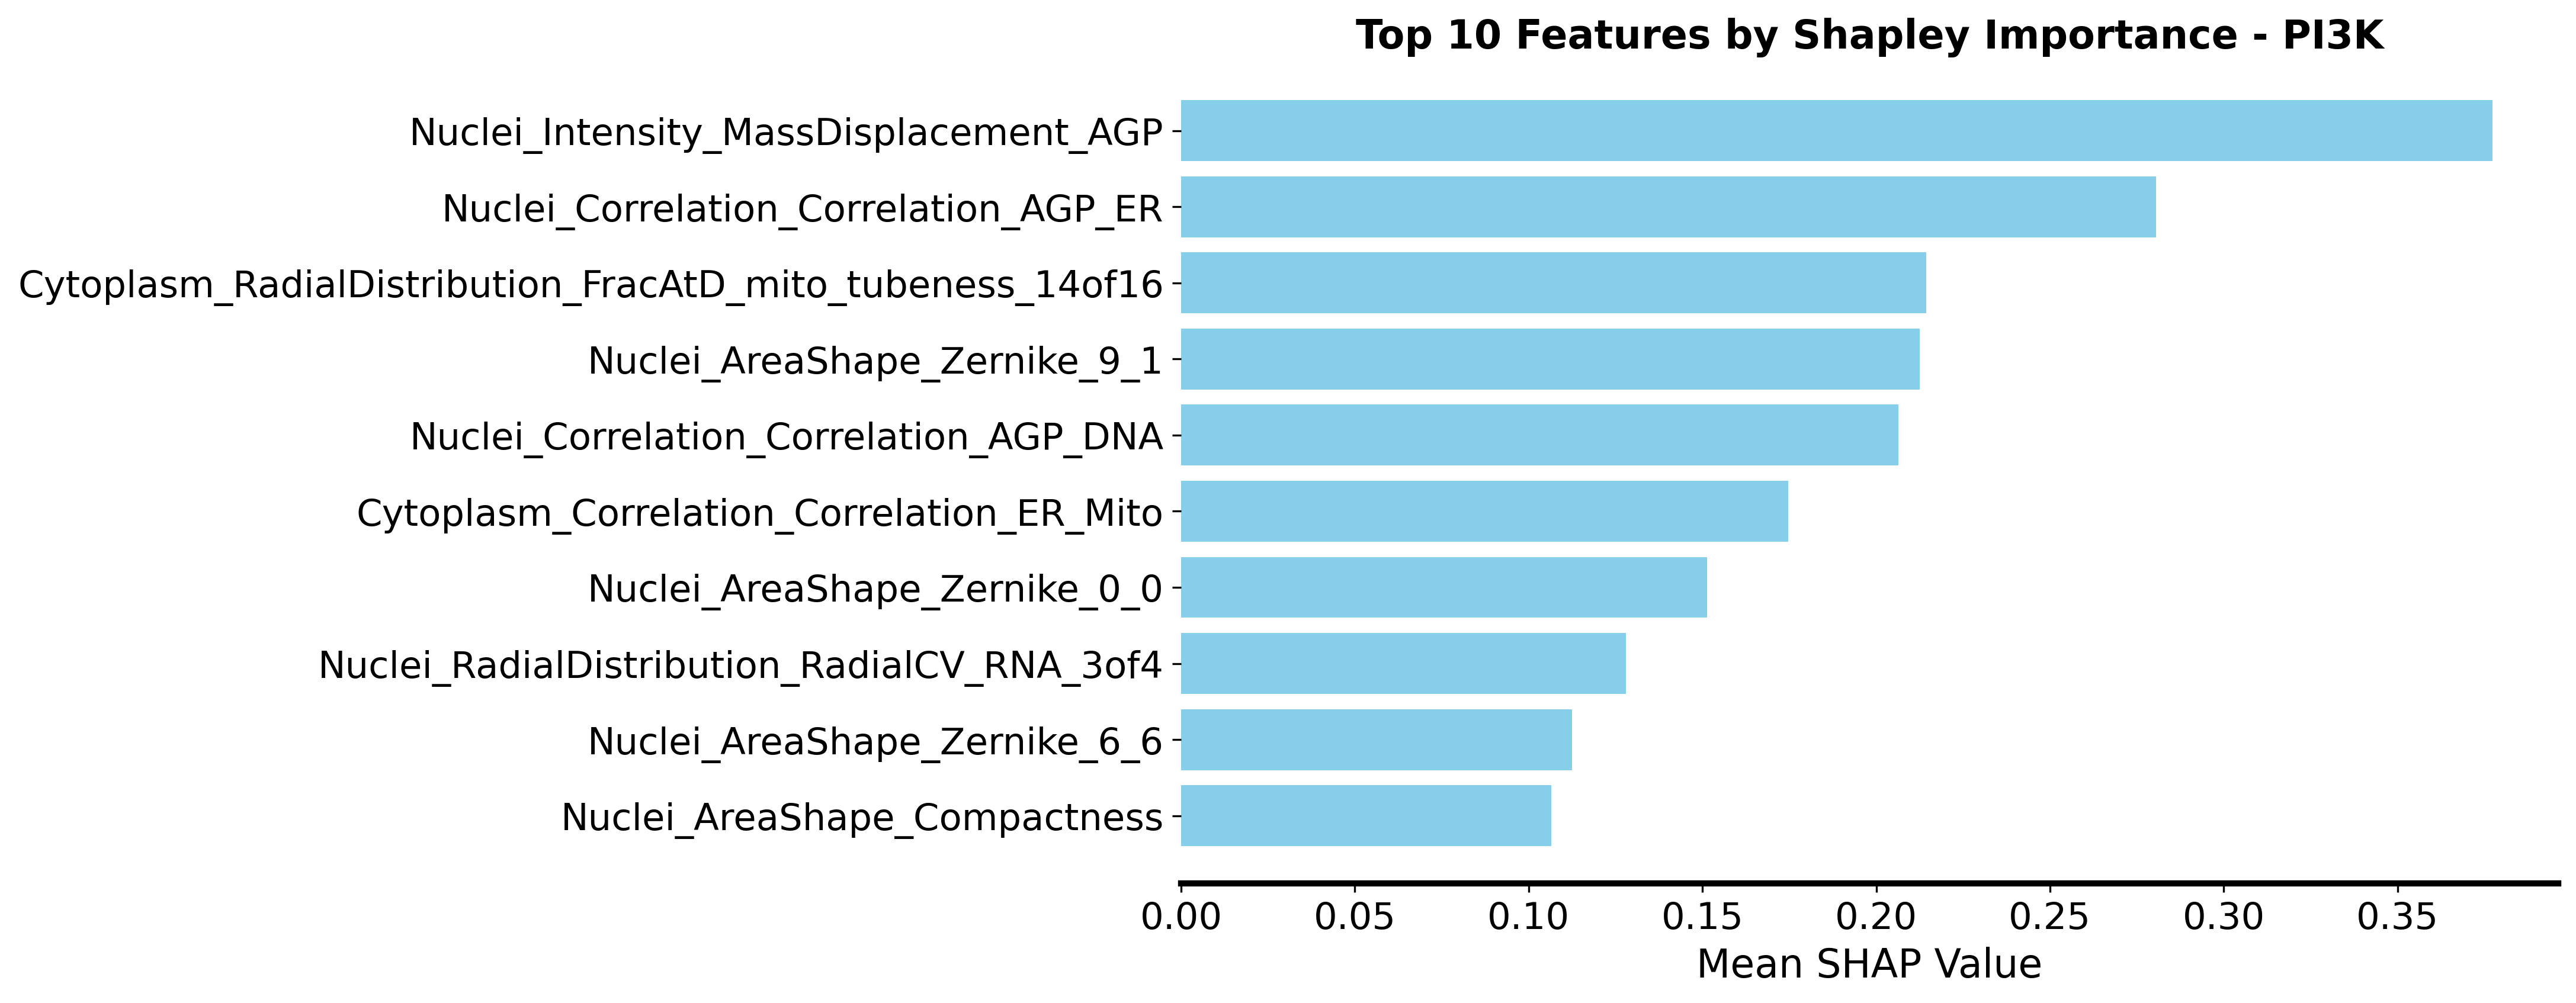

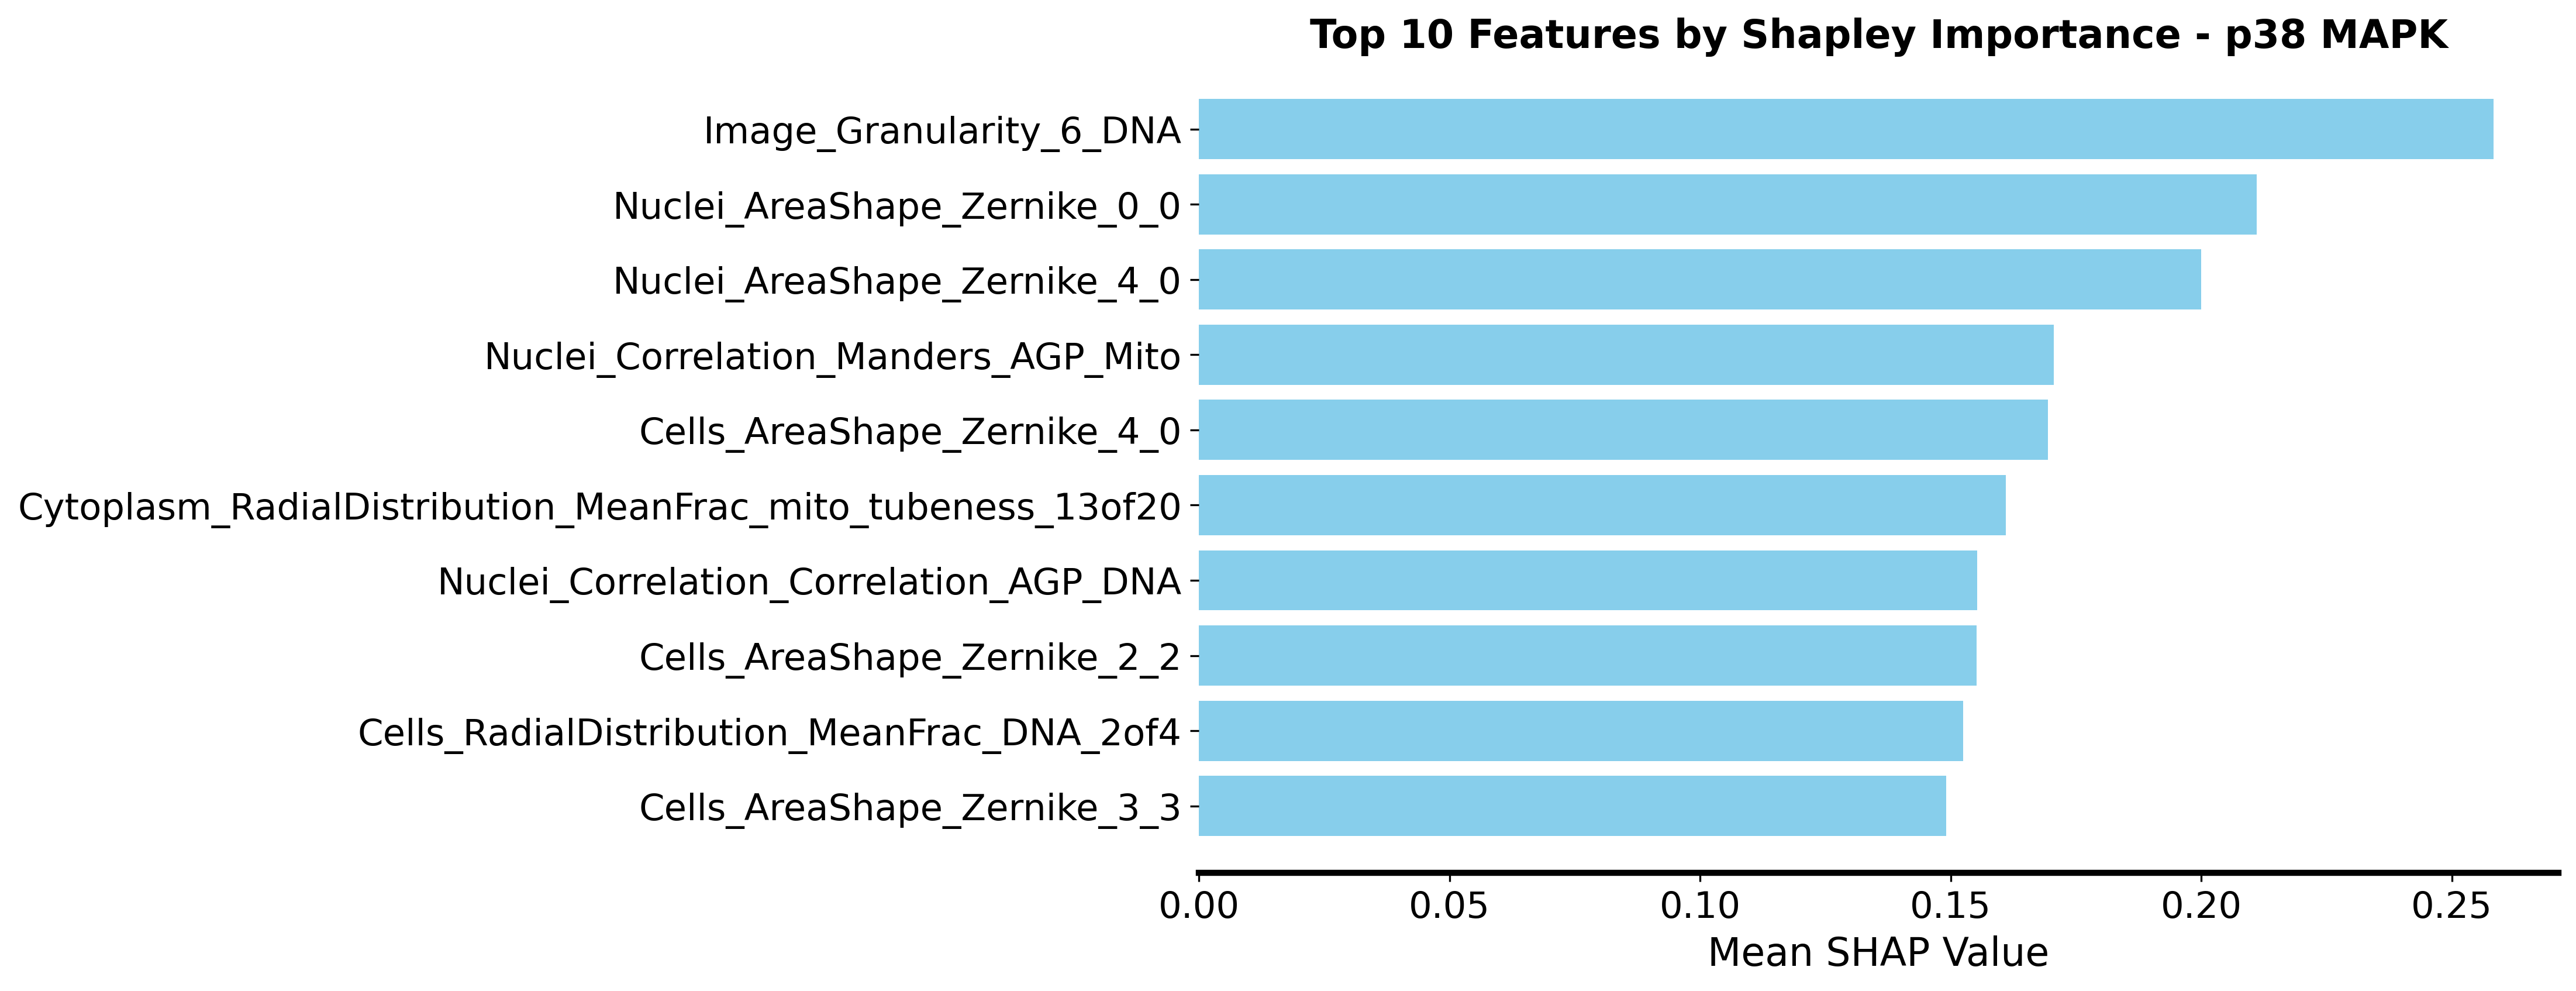

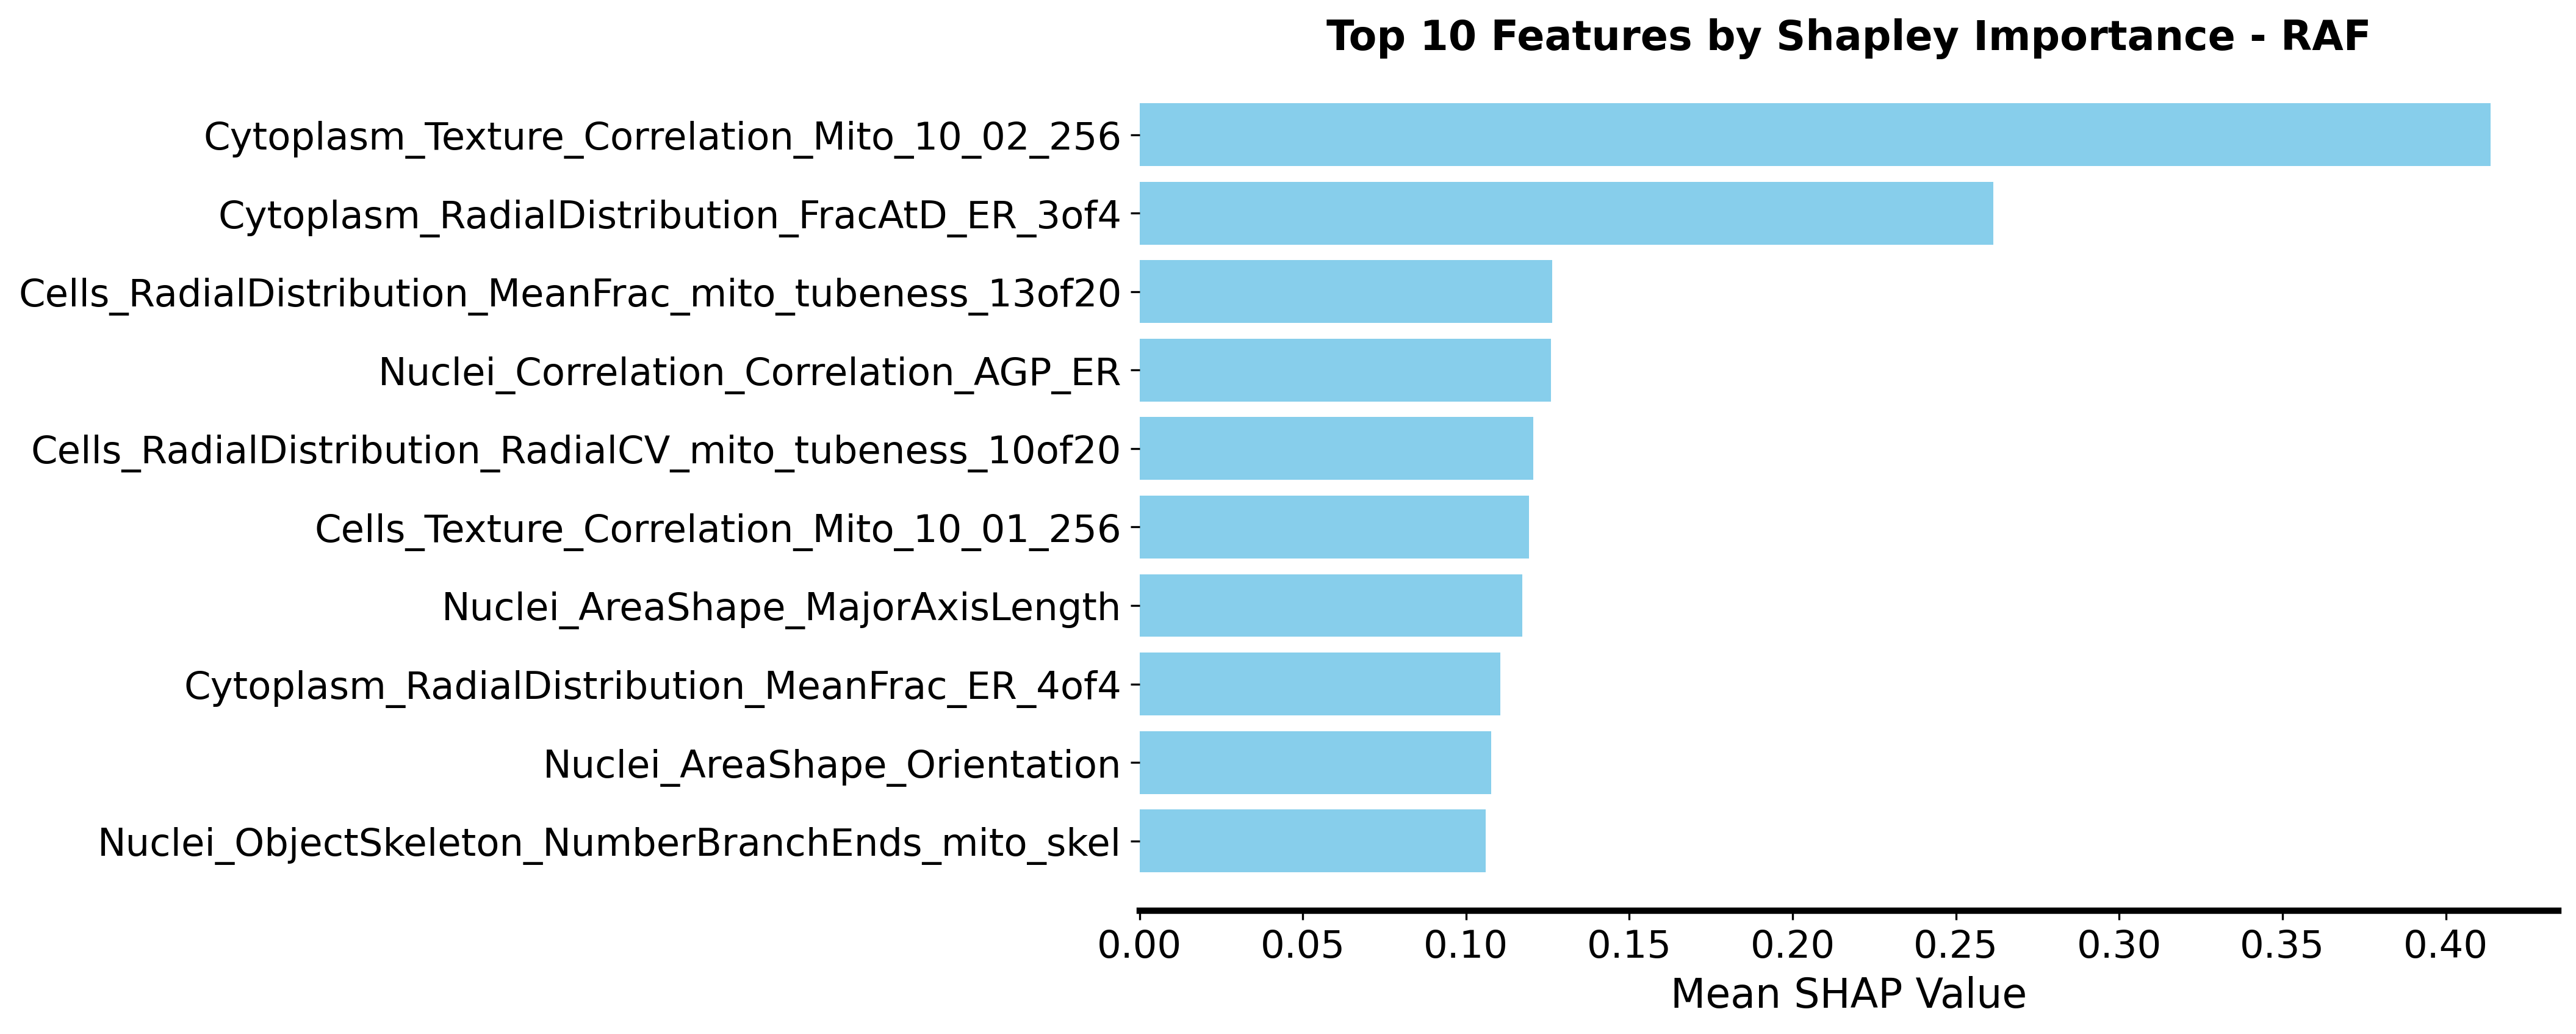

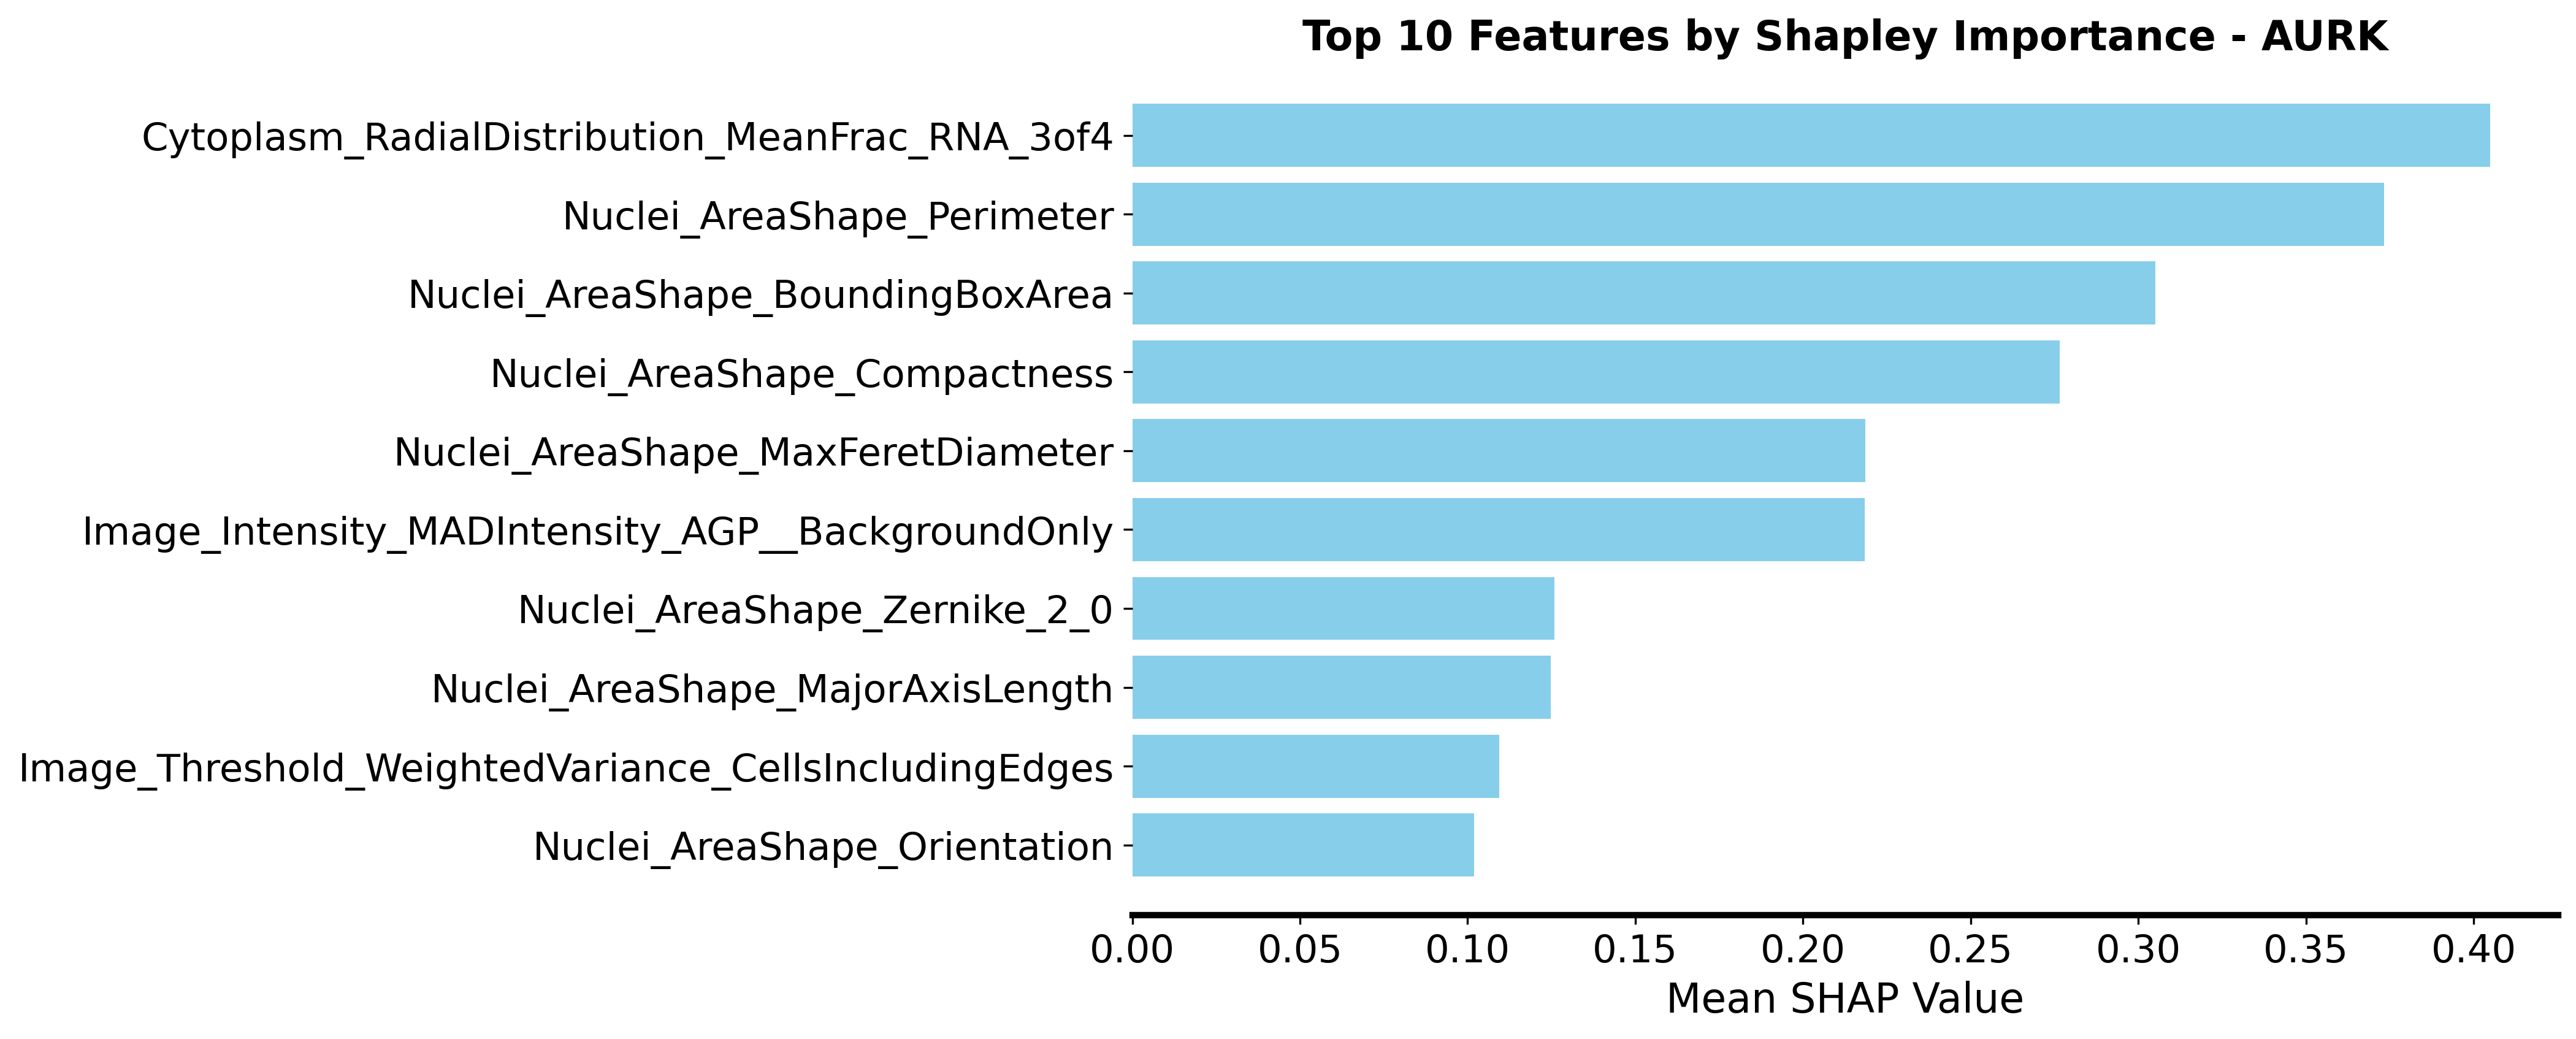

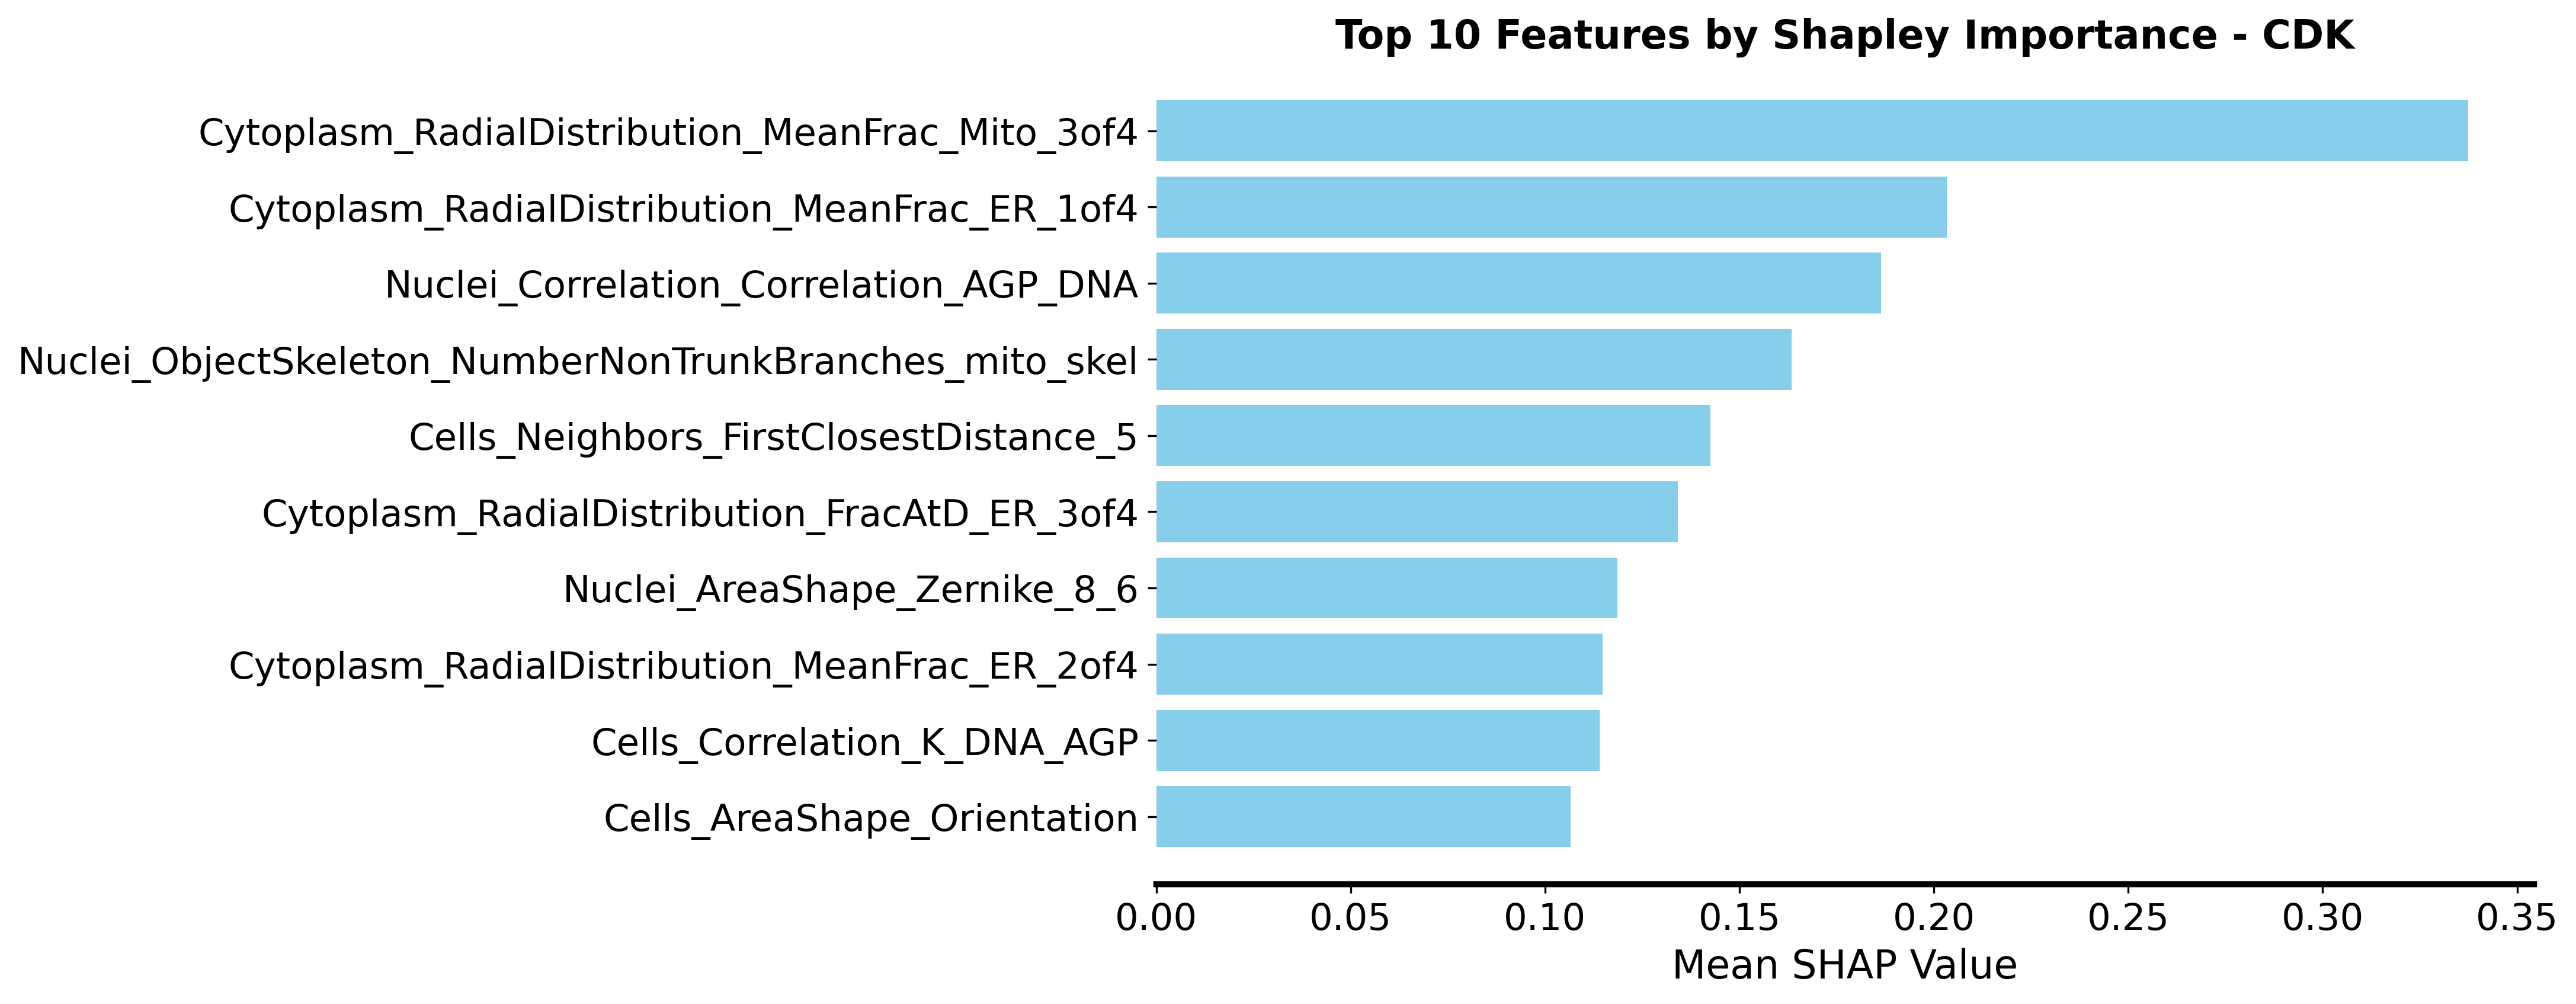

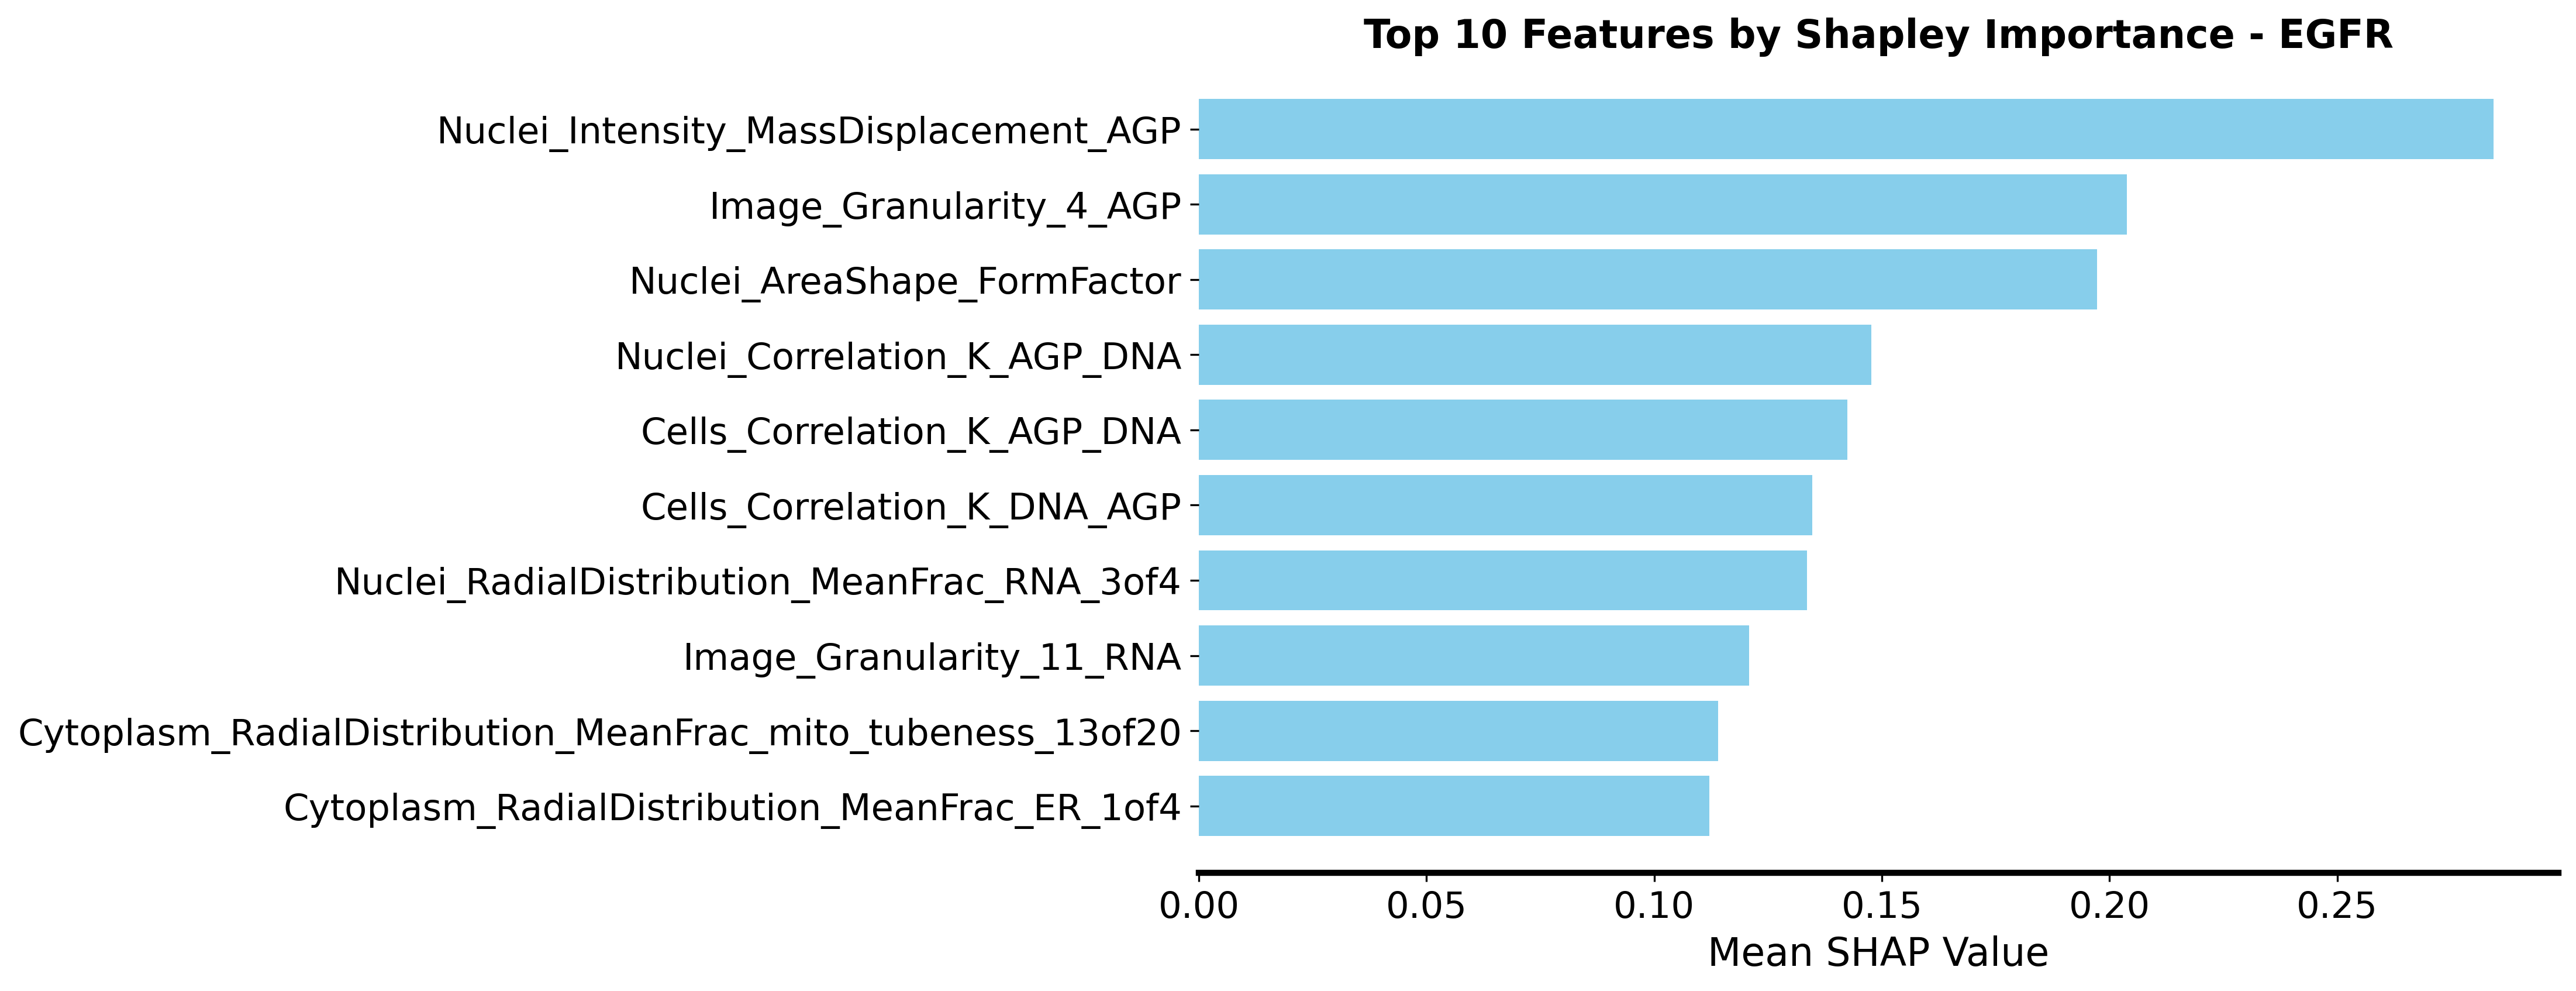

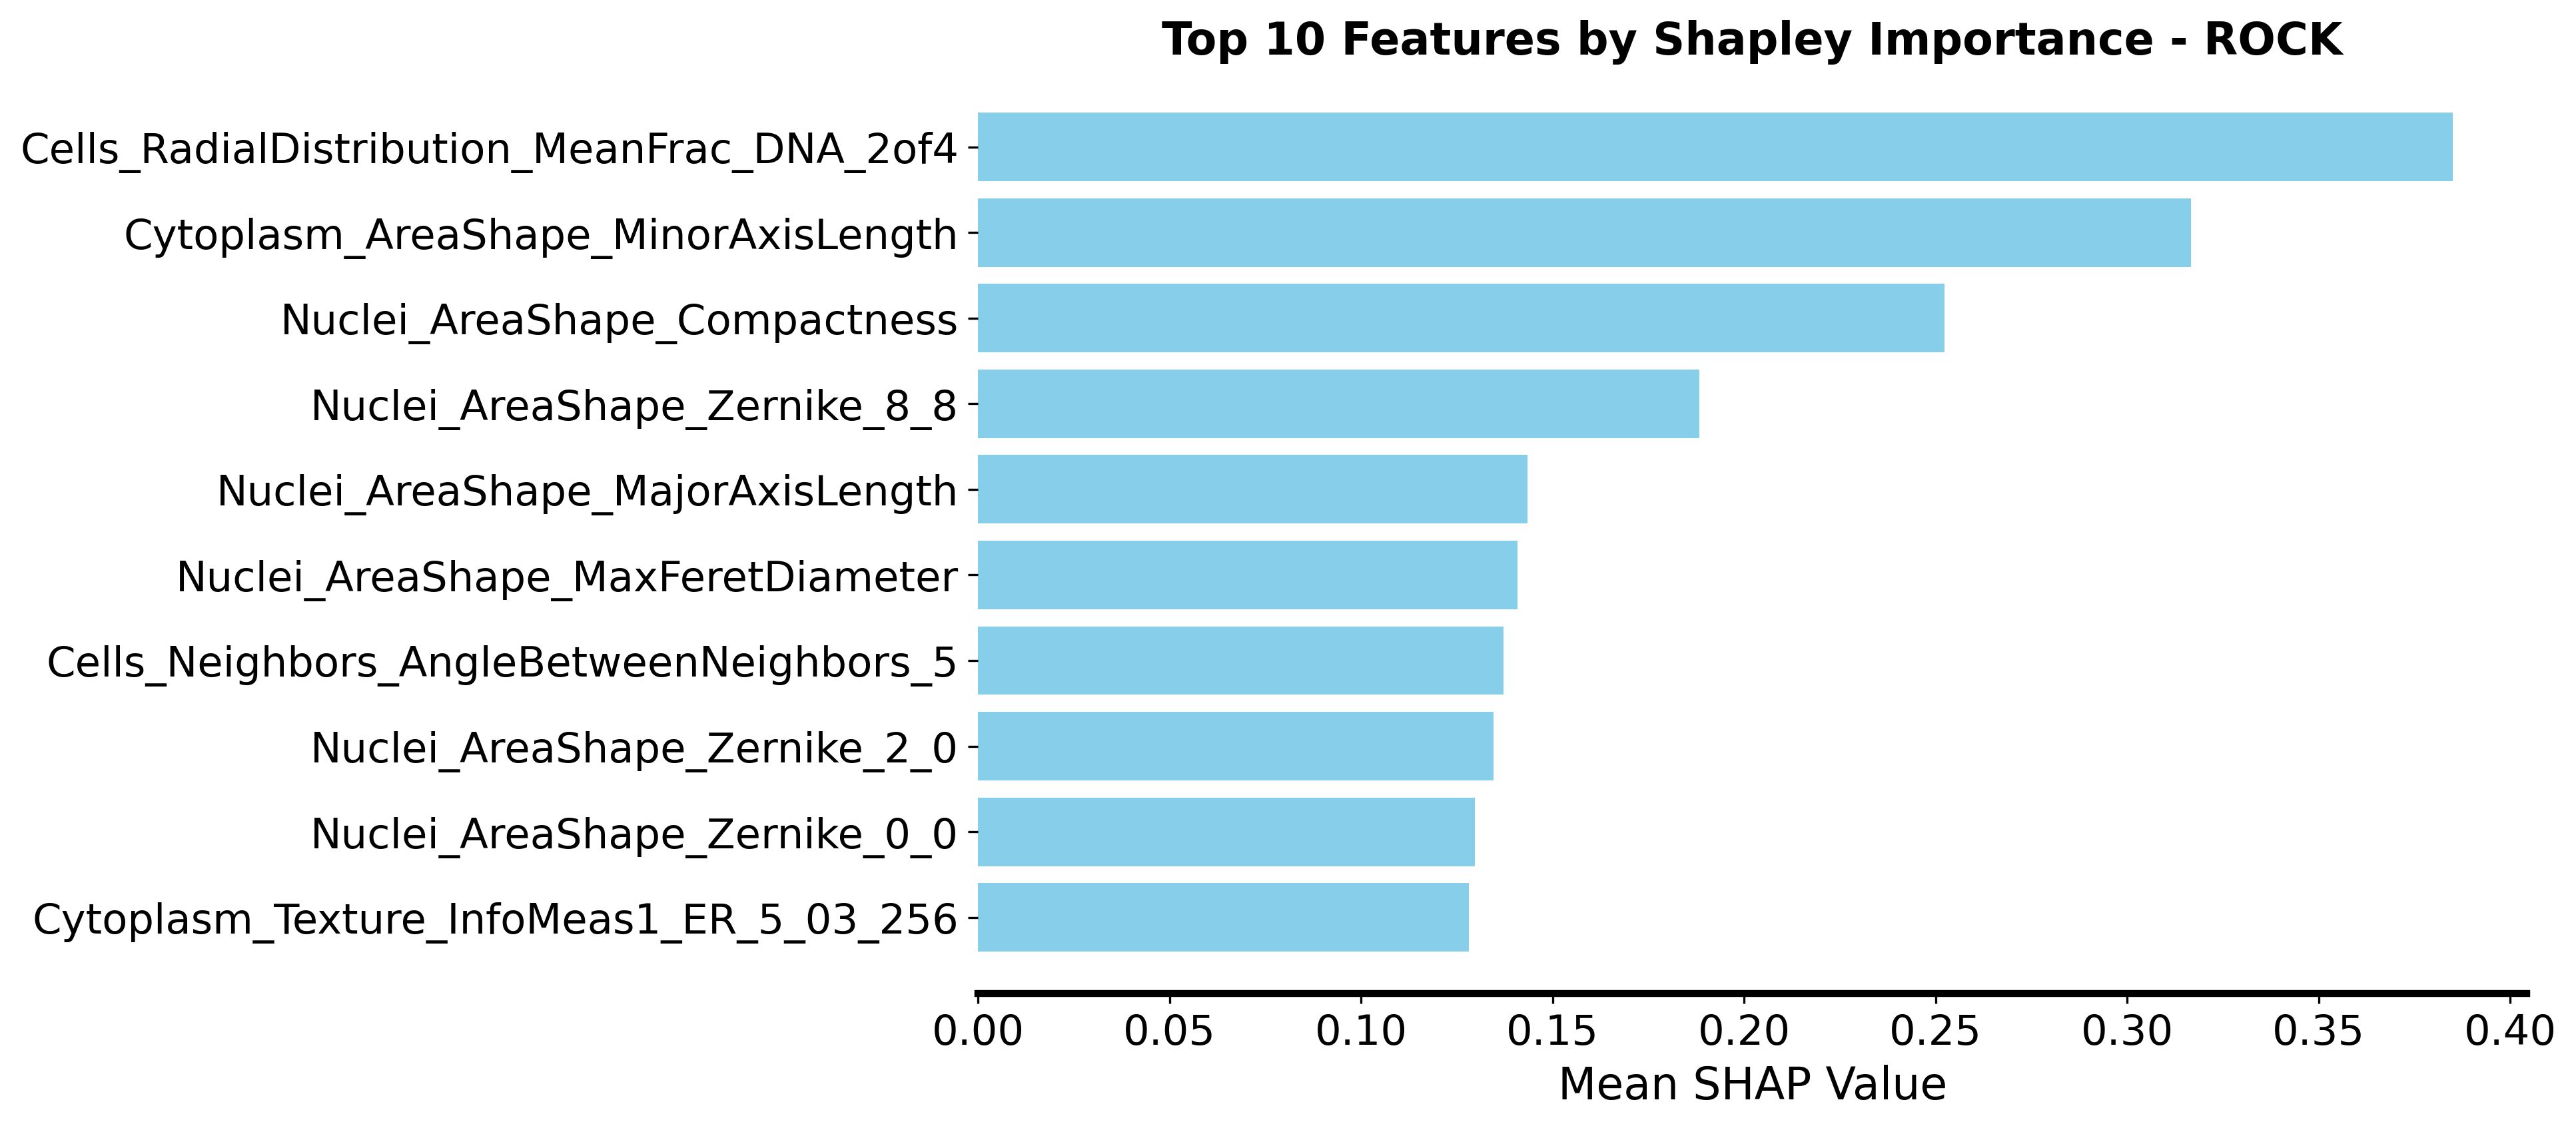

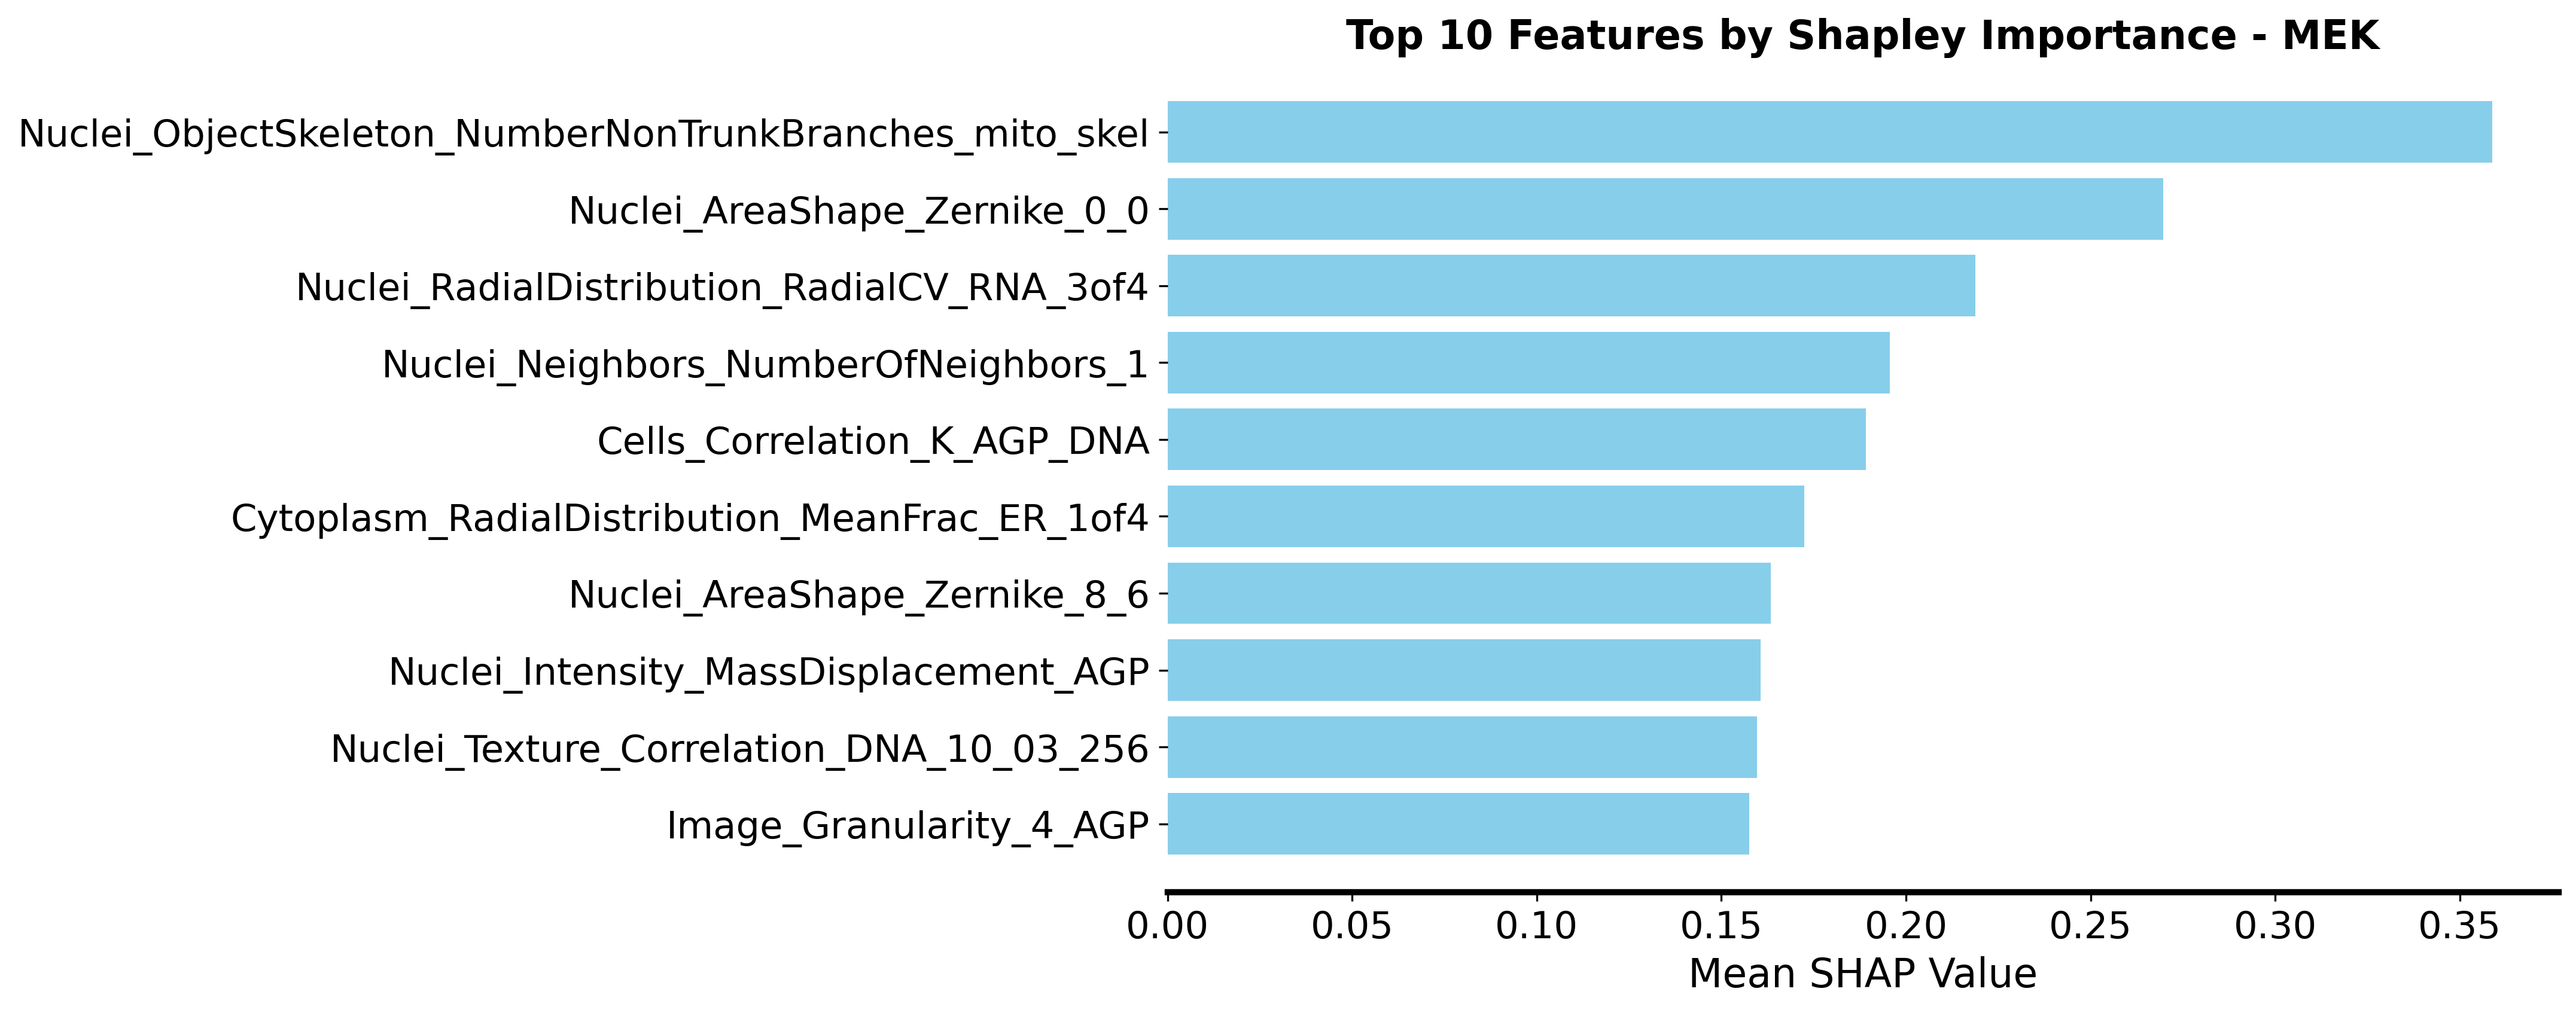

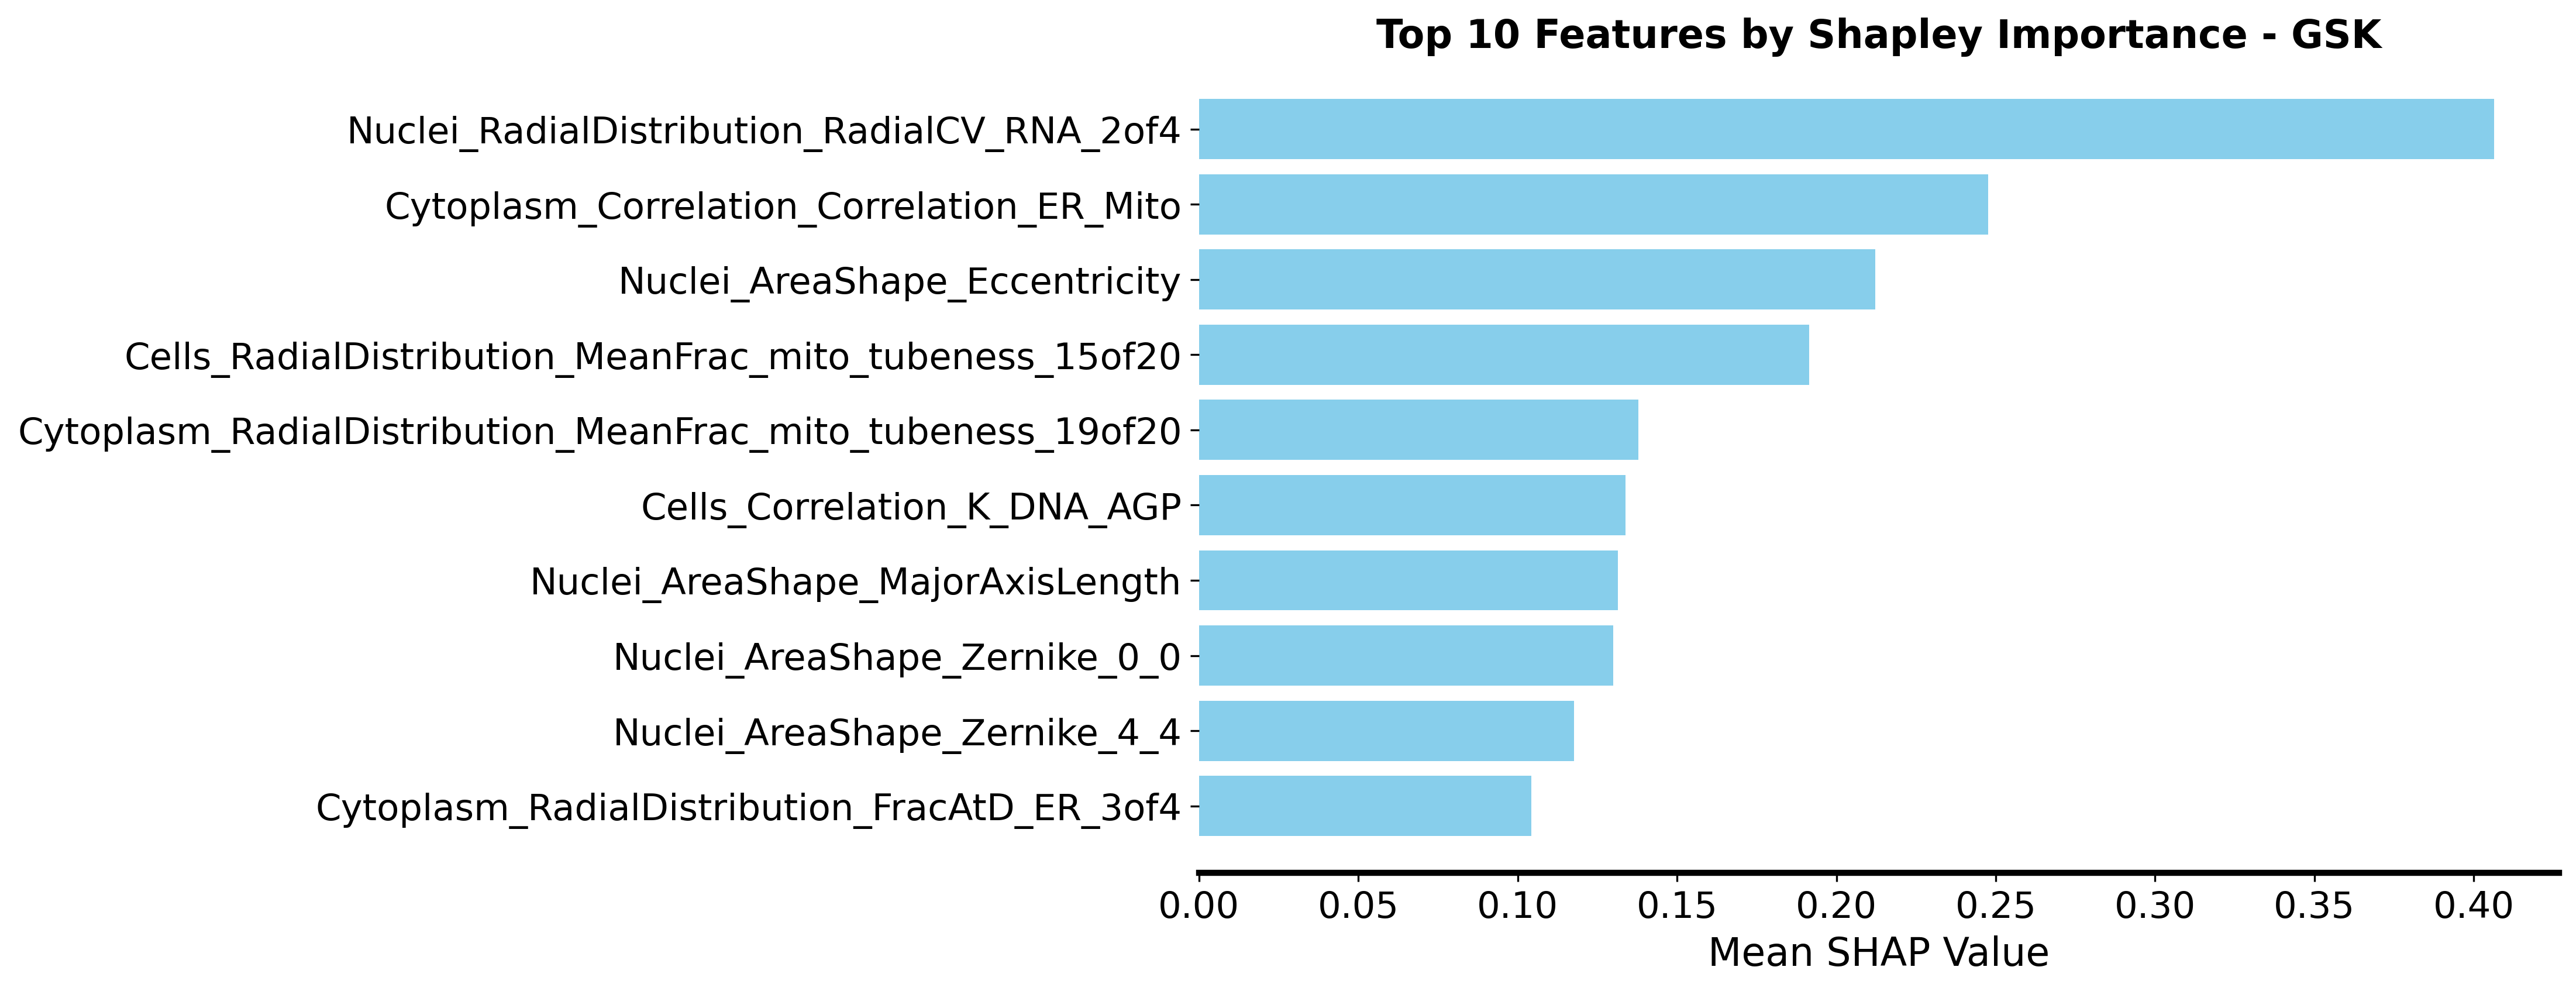

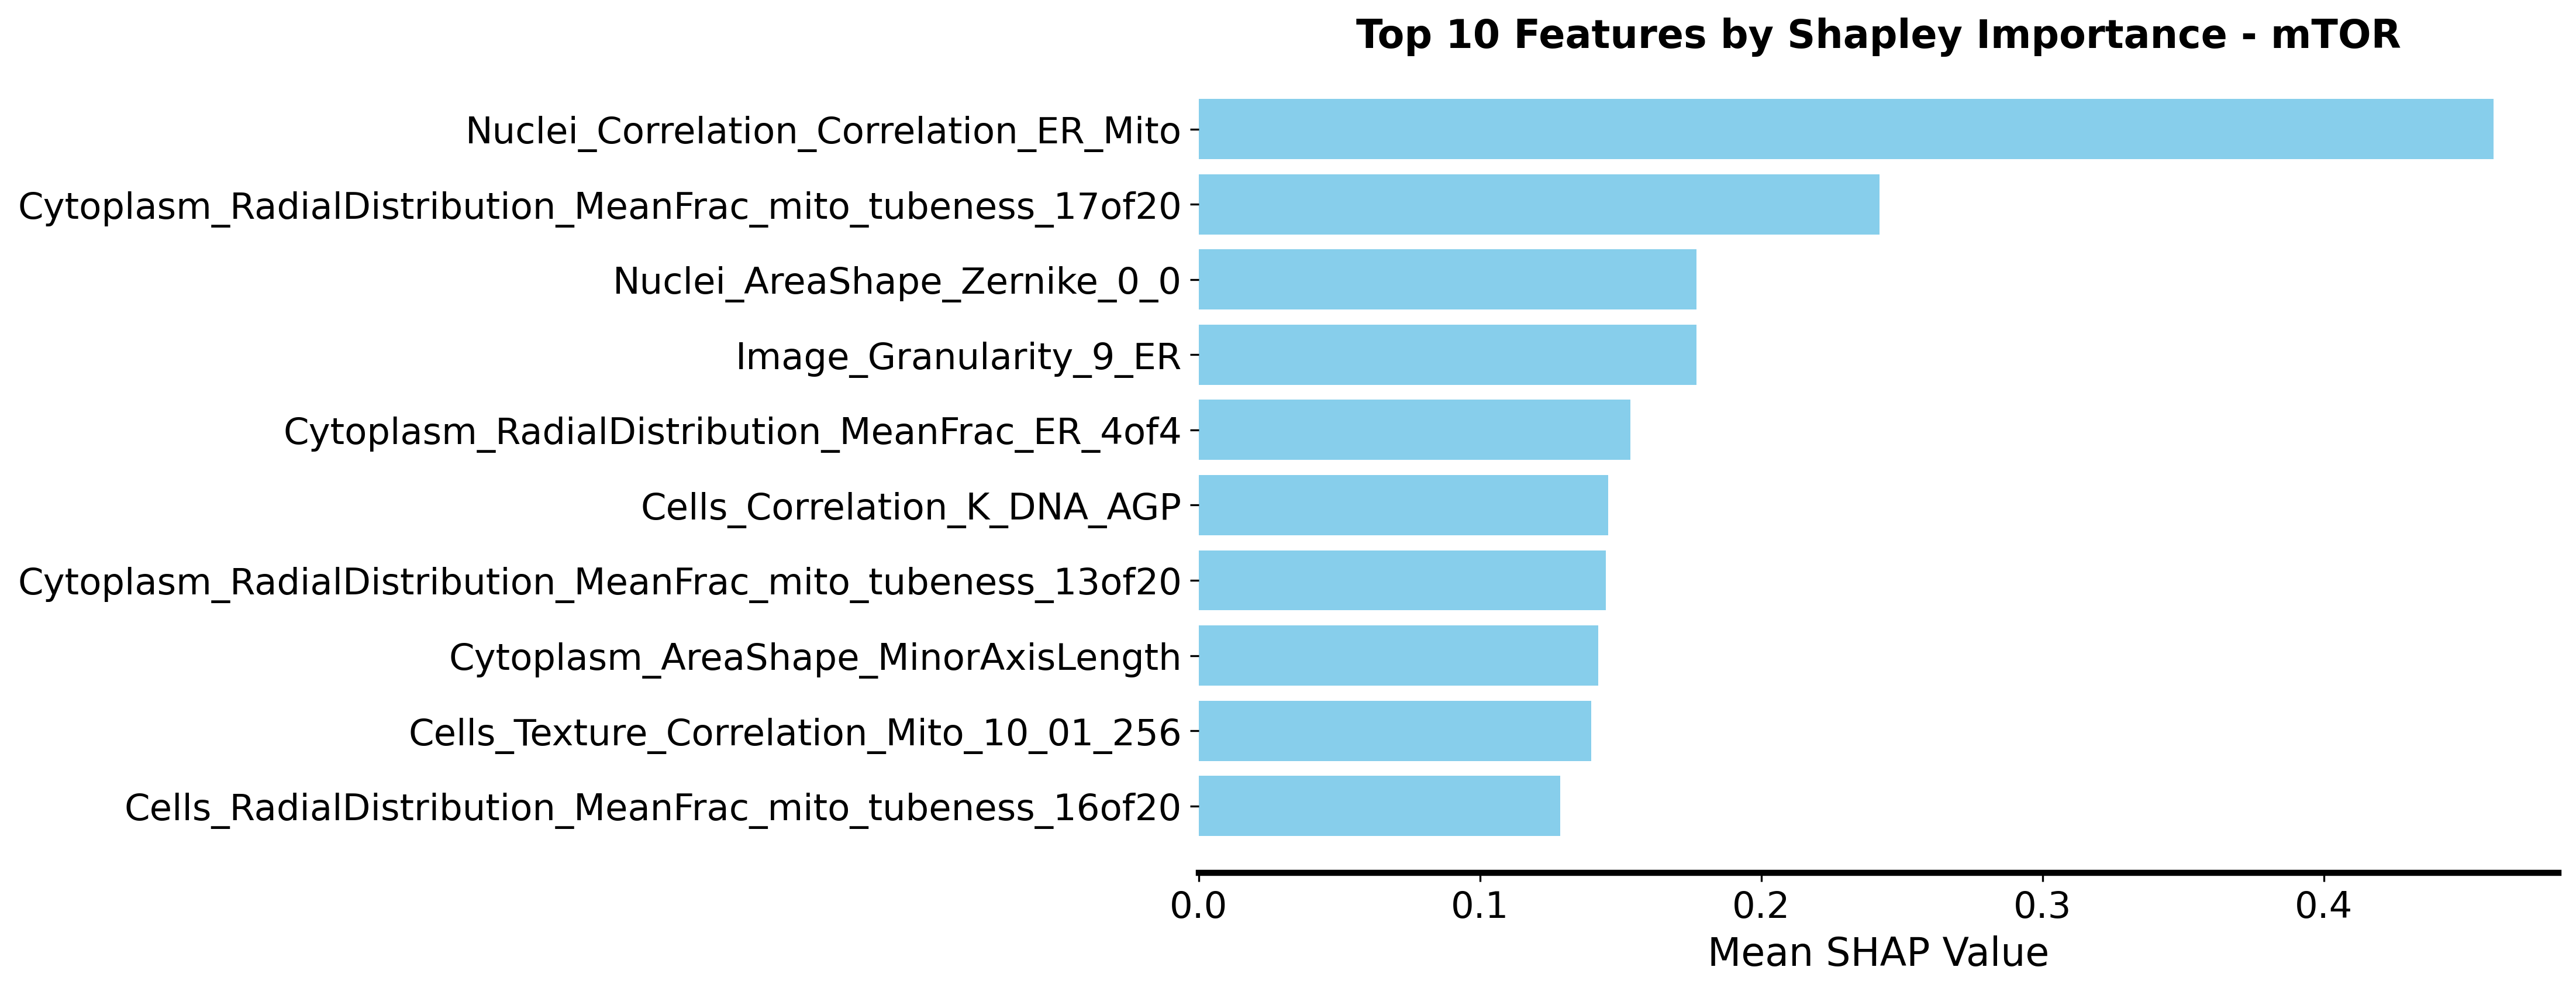

In [72]:
for i, moa in zip(list(moa_dict.values()), list(moa_dict.keys())):
    plot_shap_per_moa(class_fold_result[i], moa, f_cols, 10,
                     save_loc=f"output/Shapley/shap_imp_{moa}.png")